In [1]:
#3D Version
from mpi4py import MPI
import gmsh
from dolfinx.io import gmsh as gmshio
from dolfinx import mesh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))

comm = MPI.COMM_WORLD
rank = comm.rank

x_start, y_start = 0.25, 0.01
x_end, y_end = 0.75, 0.99

N_ref = 8


In [ ]:
#MESH GENERATION
for ref in range(N_ref+1):
    # --- user params ---
    h   = 1/(2**(ref+1))    # target size for Ω
    h_g = h/2   # target size for Γ

    gmsh.initialize()

    # ---------- Build Ω: structured quads via Gmsh ----------
    n_float = 1.0 / h
    n = int(round(n_float))
    if abs(n_float - n) > 1e-12:
        raise ValueError("For a regular Cartesian grid, choose h = 1/n (so 1/h must be an integer).")
    gmsh.model.add("Omega")

    # --- Base 2D geometry (z = 0 plane) ---
    p1 = gmsh.model.occ.addPoint(0, 0, 0)
    p2 = gmsh.model.occ.addPoint(1, 0, 0)
    p3 = gmsh.model.occ.addPoint(1, 1, 0)
    p4 = gmsh.model.occ.addPoint(0, 1, 0)

    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    cl = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([cl])
    gmsh.model.occ.synchronize()

    # --- Structured 2D mesh controls before extrusion ---
    gmsh.model.mesh.setTransfiniteCurve(l1, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l2, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l3, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l4, n + 1)
    gmsh.model.mesh.setTransfiniteSurface(surf)
    gmsh.model.mesh.setRecombine(2, surf)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

    # --- Extrude into a thin 3D slab ---
    out = gmsh.model.occ.extrude([(2, surf)], 0, 0, 0.02, numElements=[1], recombine=True)
    gmsh.model.occ.synchronize()

    # --- Define physical group for volume (dim=3) ---
    vols = [ent[1] for ent in gmsh.model.getEntities(dim=3)]
    pg_omega = gmsh.model.addPhysicalGroup(3, vols)
    gmsh.model.setPhysicalName(3, pg_omega, "Omega")

    # Optional: define boundary groups if needed
    # walls = [ent[1] for ent in gmsh.model.getEntities(dim=2)]
    # gmsh.model.addPhysicalGroup(2, walls)

    # --- Generate mesh ---
    gmsh.model.mesh.generate(3)
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.model_to_mesh(
        gmsh.model, comm, rank, gdim=3
    )[0:3]

    # --- Save Ω mesh before clearing ---
    if rank == 0:
        filename = f"Omega_ex1_{ref}.msh"
        gmsh.write(filename)

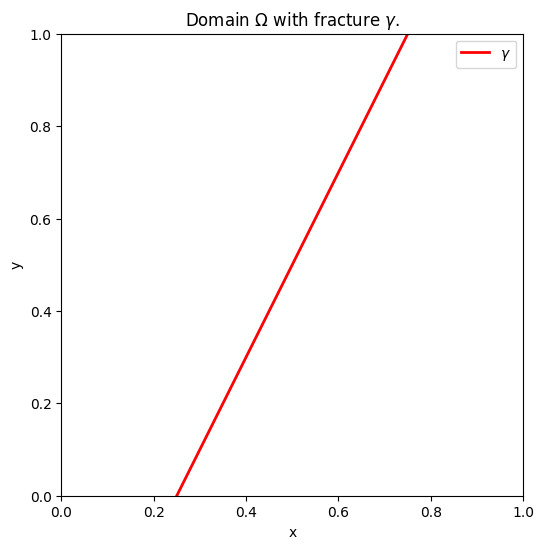

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot fracture γ
ax.plot([x_start, x_end], [y_start-0.01, y_end+0.01],
        'r-', linewidth=2, label=r"$\gamma$")

# Set exact domain bounds
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')  # force square axes

# Label and title
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"Domain $\Omega$ with fracture $\gamma$.")

# Disable autoscaling AFTER setting limits (prevents expansion)
ax.set_autoscale_on(False)

# Add legend last
ax.legend()

plt.show()

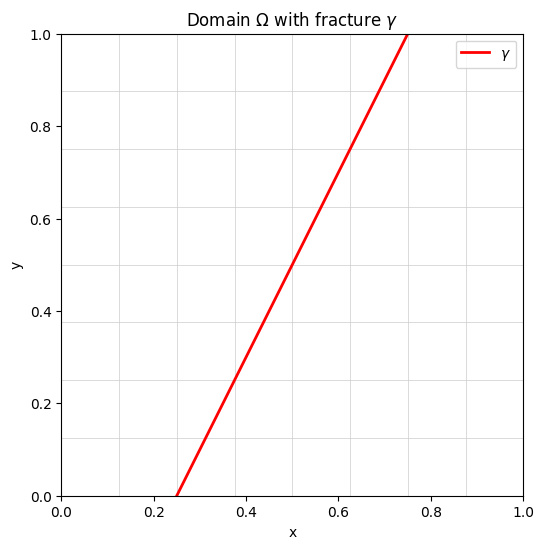

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- Extract x,y coordinates from 3D mesh Omega ---
coords = Omega.geometry.x  # shape: (num_points, 3)
x_unique = np.unique(coords[:, 0])
y_unique = np.unique(coords[:, 1])

x_min, x_max = x_unique.min(), x_unique.max()
y_min, y_max = y_unique.min(), y_unique.max()

fig, ax = plt.subplots(figsize=(6, 6))

# --- Plot mesh Ω as Cartesian grid lines ---
for x in x_unique:
    ax.plot([x, x], [y_min, y_max], color="0.8", linewidth=0.5, zorder=0)

for y in y_unique:
    ax.plot([x_min, x_max], [y, y], color="0.8", linewidth=0.5, zorder=0)

# --- Plot fracture γ on top ---
ax.plot([x_start, x_end], [y_start - 0.01, y_end + 0.01],
        'r-', linewidth=2, label=r"$\gamma$", zorder=1)

# --- Domain settings ---
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"Domain $\Omega$ with fracture $\gamma$")

ax.set_autoscale_on(False)
ax.legend()

plt.show()


In [89]:
# APPROXIMATING EXACT SOLUTION
from dolfinx import mesh, fem
import ufl
import numpy as np
# from dolfinx.cpp.mesh import compute_cell_sizes

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
ref = N_ref
filename = f"Omega_ex1_{ref}.msh"
Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
# Compute cell diameters (length of the longest edge in each cell)
# all_h = compute_cell_sizes(Omega, "max")

# For example, get average or min/max
# h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

coords = Omega.geometry.x
hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
h = min(hx, hy)
# Clear gmsh model before building Γ
# gmsh.clear()

# ================= Γ: line (1D embedded in 3D plane z=0) =================
gmsh.initialize()
h_g = h/2
gmsh.model.add("Gamma")
p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
line = gmsh.model.occ.addLine(p0, p1)
gmsh.model.occ.synchronize()

gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
gmsh.model.mesh.generate(1)

# Import Gamma mesh, embed in 3D (gdim=3)
Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

gmsh.finalize()

order = 1
V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
p_m, p_f, lmbd = ufl.TrialFunctions(W)

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(Omega)
f_m = fem.Constant(Omega, 0.0)
f_f = fem.Constant(Gamma, 0.0)

# k_m = fem.Constant(Omega, 1.0)
# Diagonal entries
k_values = np.array([[1.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])

# Define as a constant tensor field over Omega
k_m = fem.Constant(Omega, k_values)
k_f = fem.Constant(Gamma, 1.0)

dx = ufl.Measure("dx", domain=Omega)
ds = ufl.Measure("dx", domain=Gamma)

# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------
# --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
from fenicsx_ii import Average, Circle
import basix.ufl
R = np.min([0.01, h/4])        # tube/circle radius around Γ (tune as you like)
q_degree = 16   # quadrature degree along the circle (tune)

# Restriction operators for trial and test sides
restriction_trial = Circle(Gamma, R, degree=q_degree, )
restriction_test  = Circle(Gamma, R, degree=q_degree)

# Quadrature space on Γ used to represent the averages
q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)

# Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# a_m1 = -lmbd * phi * ds
a_m1 = - lmbd * avg_phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# a_l0 = p_m * mu * ds
a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(Gamma, 0.0) * mu * ds

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

# Compute bounding box to locate sides
coords = Omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
# all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
# p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[right_dofs]  = 4.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

# tolerance scaled to Γ
tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

# locate dofs at each tip
tip1_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                             np.isclose(x[1], y_start, atol=tol_g))
)
tip2_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                             np.isclose(x[1], y_end, atol=tol_g))
)
# OR (ii) Different values at the two tips -> two BC objects
both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

# one Function-valued BC with piecewise values
pf_fun = fem.Function(V_f)
# pf_fun.x.array[:] = 0.0
pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

bc_pf = fem.dirichletbc(pf_fun, both_tips)

# add it
bcs = [bc_pm, bc_pf]

a = a_m + a_gamma
L = L_m + L_gamma

from fenicsx_ii import LinearProblem, assemble_scalar
petsc_options = {
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "ksp_error_if_not_converged": True,
}
problem = LinearProblem(
    a,
    L,
    petsc_options_prefix="coupled_poisson",
    petsc_options=petsc_options,
    bcs=bcs,
)
p_m, p_f, lmbd = problem.solve()
p_m.name = "p_m"
p_f.name = "p_f"
lmbd.name = "lmbd"

p_m_exact = p_m
p_f_exact = p_f
lmbd_exact = lmbd

Info    : Reading 'Omega_ex1_8.msh'...
Info    : 27 entities
Info    : 526338 nodes
Info    : 262144 elements                                                                                     
Info    : Done reading 'Omega_ex1_8.msh'                                                                         
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000608677s, CPU 0.001161s)
Info    : 1128 nodes 1129 elements


Exception ignored in: <function LinearProblem.__del__ at 0x738ed838aa20>
Traceback (most recent call last):
  File "/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/dolfinx/fem/petsc.py", line 883, in __del__
    lambda obj: obj is not None, (self._solver, self._A, self._b, self._x, self._P_mat)
AttributeError: 'LinearProblem' object has no attribute '_solver'


Info    : Reading 'Omega_ex1_0.msh'...
Info    : 27 entities
Info    : 18 nodes
Info    : 4 elements
Info    : Done reading 'Omega_ex1_0.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000208974s, CPU 0.000349s)
Info    : 6 nodes 7 elements


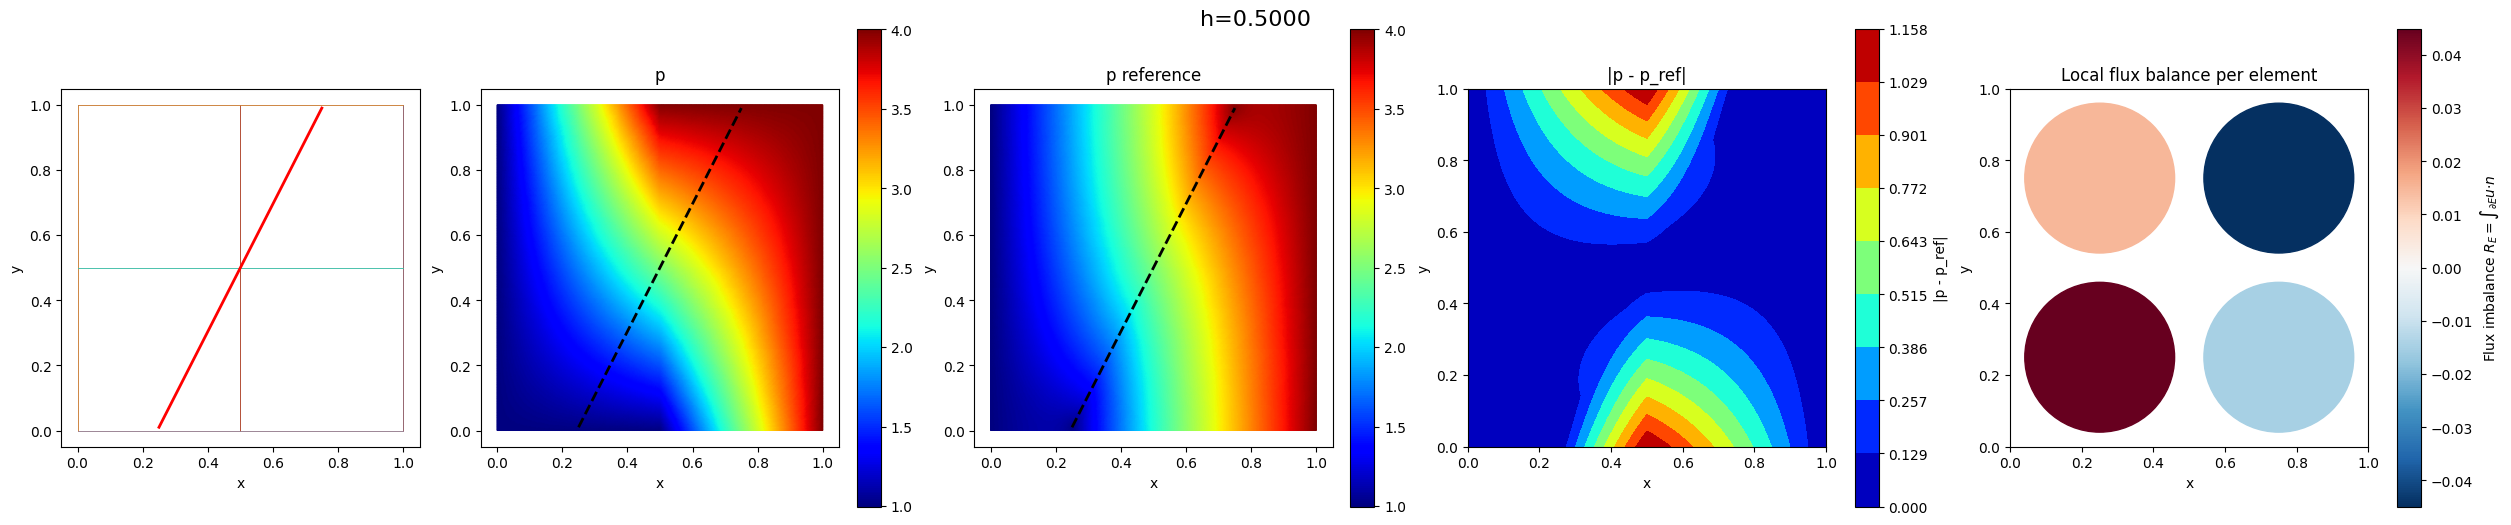

Info    : Reading 'Omega_ex1_1.msh'...
Info    : 27 entities
Info    : 50 nodes
Info    : 16 elements
Info    : Done reading 'Omega_ex1_1.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000334154s, CPU 0.000481s)
Info    : 10 nodes 11 elements


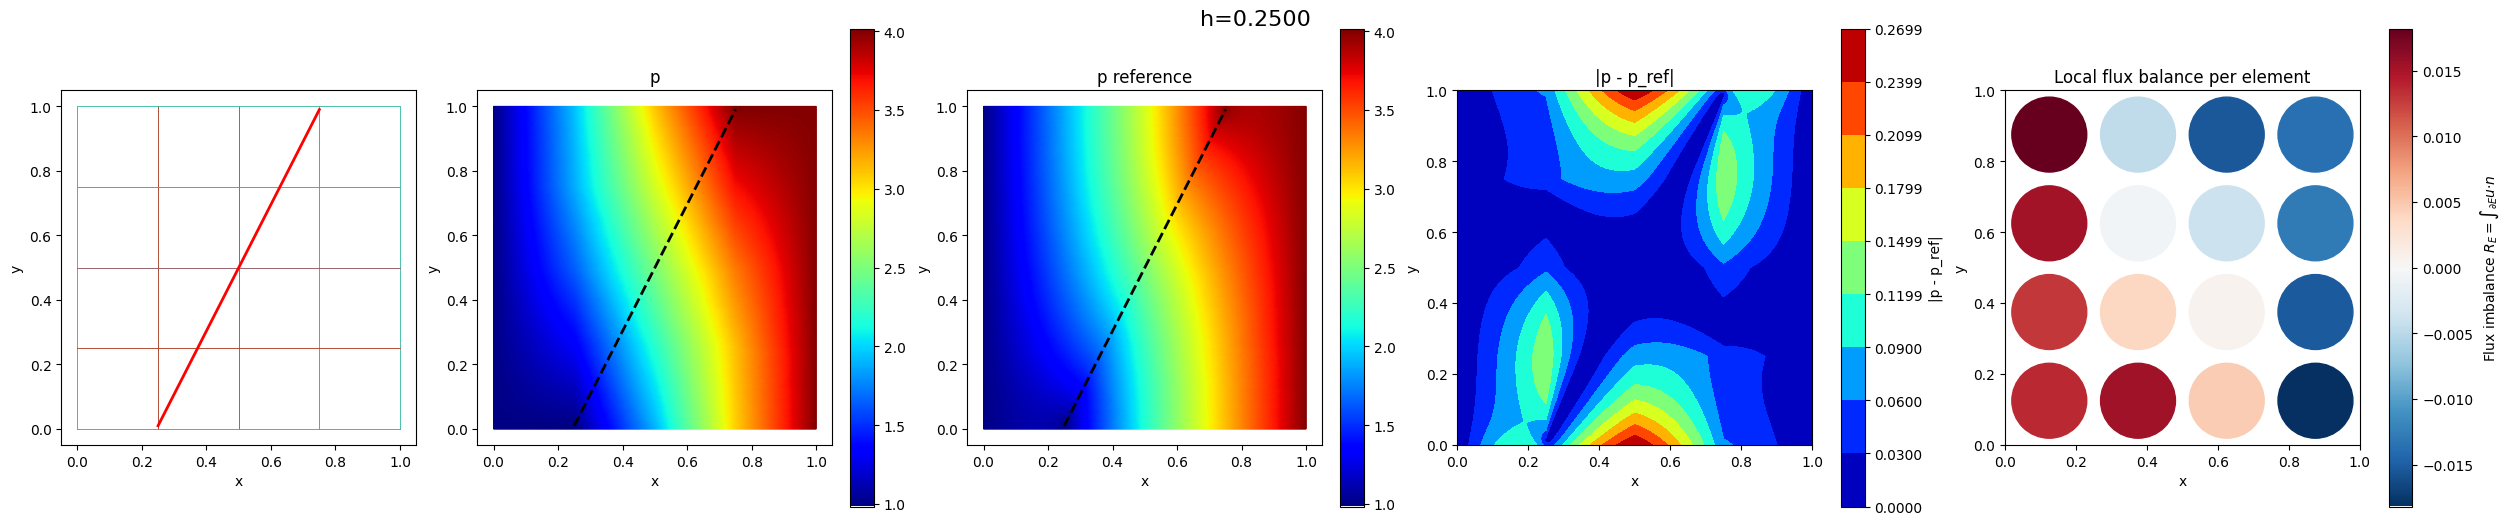

Info    : Reading 'Omega_ex1_2.msh'...
Info    : 27 entities
Info    : 162 nodes
Info    : 64 elements
Info    : Done reading 'Omega_ex1_2.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000109277s, CPU 0.000253s)
Info    : 19 nodes 20 elements


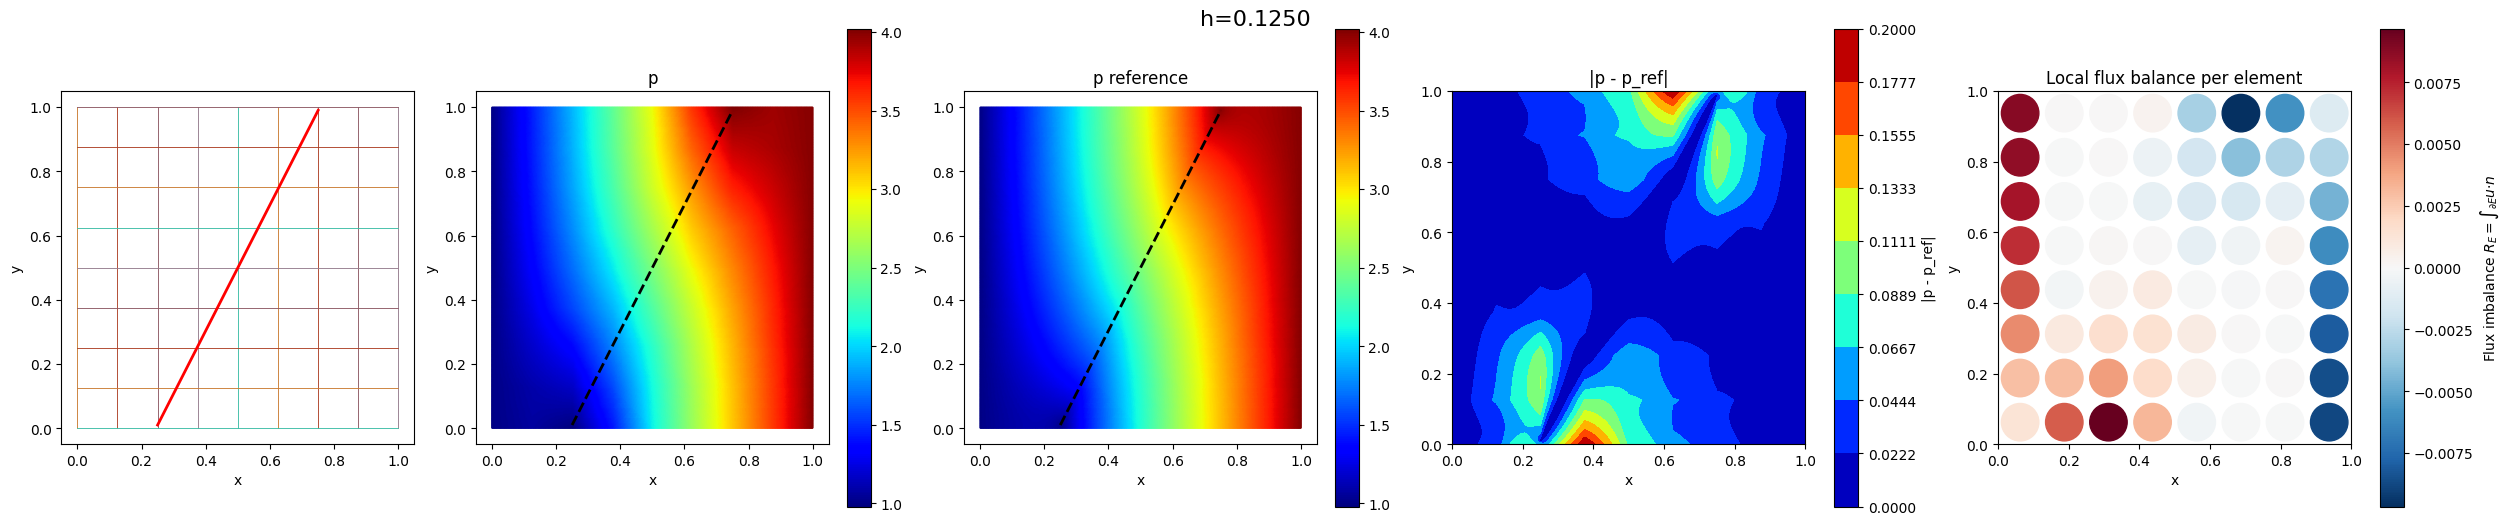

Info    : Reading 'Omega_ex1_3.msh'...
Info    : 27 entities
Info    : 578 nodes
Info    : 256 elements
Info    : Done reading 'Omega_ex1_3.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000106646s, CPU 0.000254s)
Info    : 37 nodes 38 elements


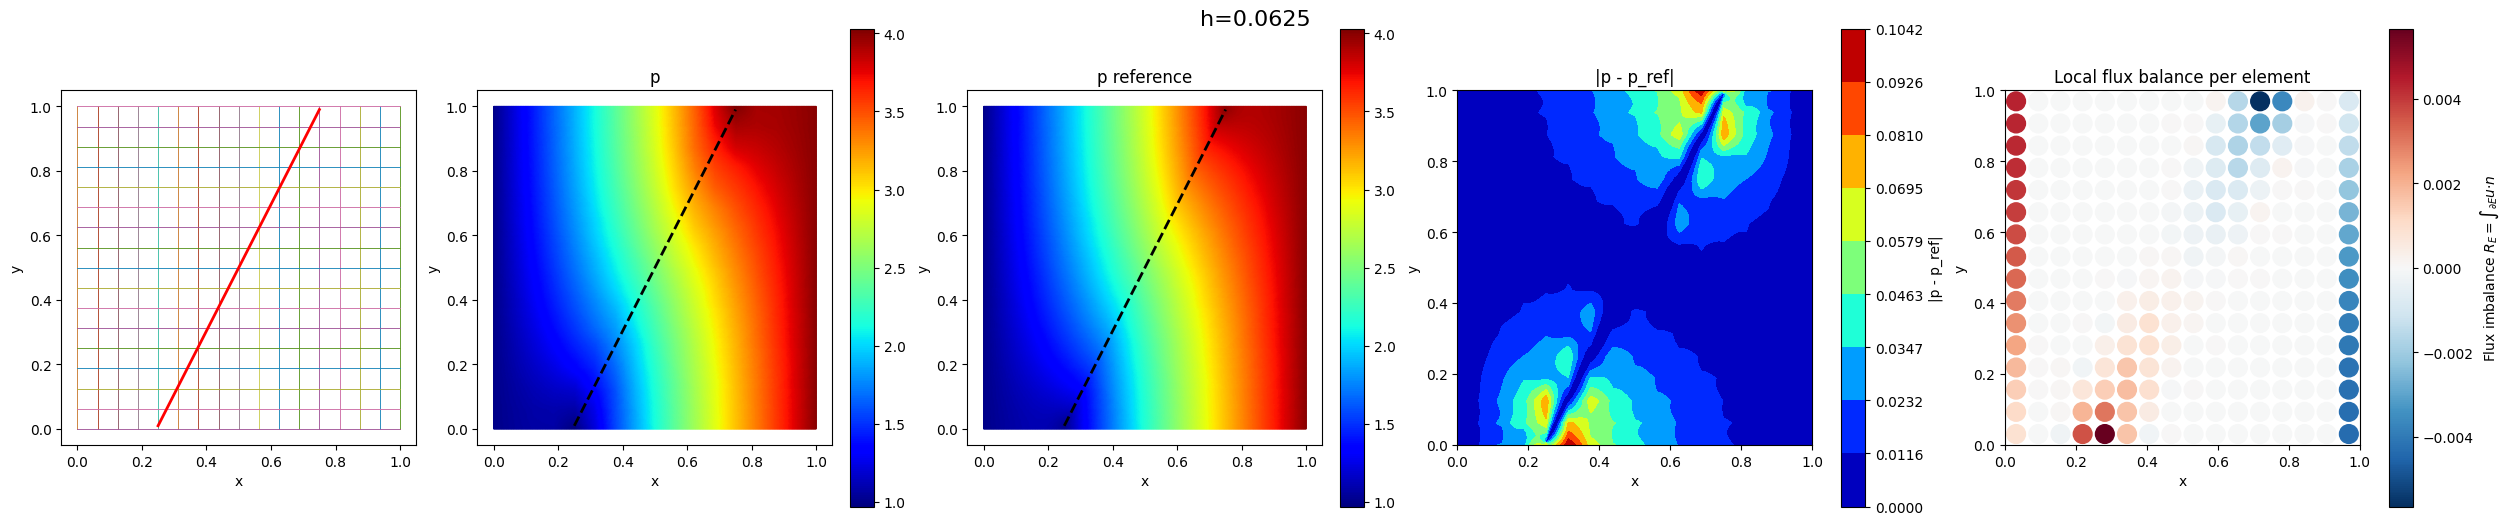

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


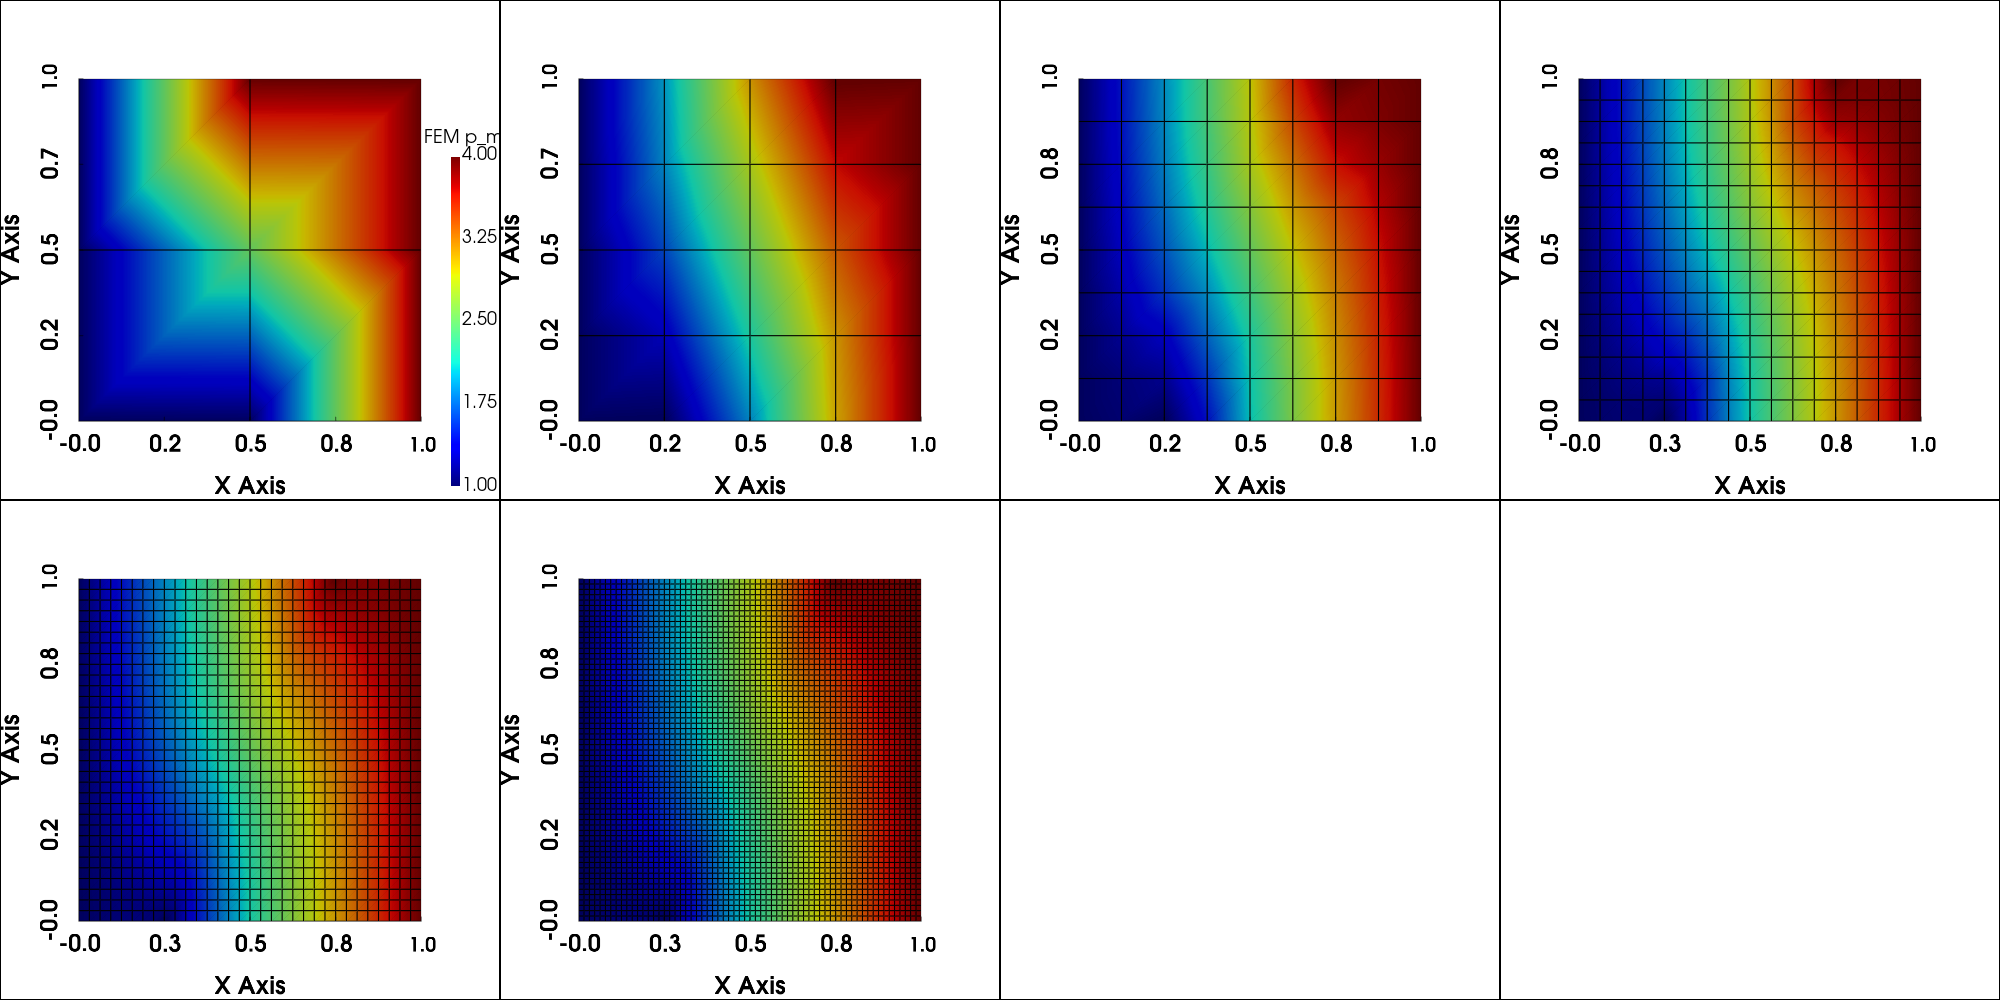

In [90]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # --- Trees on the COARSE mesh (we will evaluate p on the coarse mesh) ---
    bbt_coarse = geometry.bb_tree(mesh_coarse, tdim)
    mid_tree_coarse = geometry.create_midpoint_tree(
        mesh_coarse, tdim,
        np.arange(mesh_coarse.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the FINE space: p_coarse sampled at fine DoF points ---
    # p_exact is defined on the fine mesh, so reuse its function space
    p_coarse_on_exact = fem.Function(p_exact.function_space)

    def eval_p_coarse_on_points(x: np.ndarray) -> np.ndarray:
        """Return coarse solution p evaluated at points x on the FINE mesh."""
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on COARSE mesh
        cands = geometry.compute_collisions_points(bbt_coarse, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_coarse, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest coarse cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_coarse, mid_tree_coarse, mesh_coarse, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate coarse solution p at those points/cells
        vals_1d = p.eval(X3, cells)  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)
        # For vector-valued fields, adapt as in your comment.

    # Interpolate coarse solution into fine space
    p_coarse_on_exact.interpolate(eval_p_coarse_on_points)

    # --- Integrate on the FINE mesh/domain ---
    dx = ufl.dx(domain=mesh_fine)
    err = p_exact - p_coarse_on_exact

    # ||err||_L2^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_coarse_on_exact, p_coarse_on_exact) * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_coarse_on_exact), ufl.grad(p_coarse_on_exact)) * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,   # <-- often what people plot as “H1 error”
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_nonconforming_lc")
outdir.mkdir(exist_ok=True)
dict_pm = {}
dict_lmbd = {}
for ref in range(N_ref-4):
    filename = f"Omega_ex1_{ref}.msh"
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
    tdim = Omega.topology.dim  # 2
    # fdim = 1             # 1
    # Compute cell diameters (length of the longest edge in each cell)
    # all_h = compute_cell_sizes(Omega, "max")

    # For example, get average or min/max
    # h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

    coords = Omega.geometry.x
    hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
    hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
    h = min(hx, hy)
    # Clear gmsh model before building Γ
    # gmsh.clear()

    # ================= Γ: line (1D embedded in 3D plane z=0) =================
    gmsh.initialize()
    h_g = h/2
    gmsh.model.add("Gamma")
    p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
    p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
    line = gmsh.model.occ.addLine(p0, p1)
    gmsh.model.occ.synchronize()

    gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
    pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
    gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
    gmsh.model.mesh.generate(1)

    # Import Gamma mesh, embed in 3D (gdim=3)
    Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

    gmsh.finalize()

    order = 1
    V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
    V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
    V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
    W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

    # ---------------------------------------------------------------------
    # 3. Trial and Test functions
    # ---------------------------------------------------------------------
    phi, psi, mu = ufl.TestFunctions(W)
    p_m, p_f, lmbd = ufl.TrialFunctions(W)

    # ---------------------------------------------------------------------
    # 4. Spatial coordinates and given data
    # ---------------------------------------------------------------------
    x = ufl.SpatialCoordinate(Omega)
    f_m = fem.Constant(Omega, 0.0)
    f_f = fem.Constant(Gamma, 0.0)

    # k_m = fem.Constant(Omega, 1.0)
    # Diagonal entries
    k_values = np.array([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0]])

    # Define as a constant tensor field over Omega
    k_m = fem.Constant(Omega, k_values)
    k_f = fem.Constant(Gamma, 1.0)

    dx = ufl.Measure("dx", domain=Omega)
    ds = ufl.Measure("dx", domain=Gamma)

    # ---------------------------------------------------------------------
    # 5. Weak formulations
    # ---------------------------------------------------------------------
    # --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
    from fenicsx_ii import Average, Circle
    import basix.ufl
    R = np.min([0.01, h/4])         # tube/circle radius around Γ (tune as you like)
    q_degree = 16   # quadrature degree along the circle (tune)

    # Restriction operators for trial and test sides
    restriction_trial = Circle(Gamma, R, degree=q_degree)
    restriction_test  = Circle(Gamma, R, degree=q_degree)

    # Quadrature space on Γ used to represent the averages
    q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
    Rs   = fem.functionspace(Gamma, q_el)

    # Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
    avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
    avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

    # --- Bulk domain Ω ---------------------------------------------------
    a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
    # a_m1 = -lmbd * phi * ds
    a_m1 = - lmbd * avg_phi * ds
    a_m = a_m0 + a_m1
    L_m = f_m * phi * dx

    # --- Interface Γ -----------------------------------------------------
    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f = a_f0 + a_f1
    L_f = f_f * psi * ds

    # --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
    # a_l0 = p_m * mu * ds
    a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
    a_l1 = -p_f * mu * ds
    a_l = a_l0 + a_l1
    L_l = fem.Constant(Gamma, 0.0) * mu * ds

    # ---------------------------------------------------------------------
    # 6. Combine interface weak form
    # ---------------------------------------------------------------------
    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    F = a_m - L_m + a_gamma - L_gamma
    residual = ufl.extract_blocks(F)

    # Compute bounding box to locate sides
    coords = Omega.geometry.x
    x = coords[:, 0]
    y = coords[:, 1]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Tolerance for side detection
    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # Locate dofs on each side
    left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
    right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
    bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
    top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

    # Union of all boundary dofs for which we enforce a value
    # all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
    all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

    # Build a Function-valued BC so we can assign side-dependent values
    p_m_bc = fem.Function(V_m)
    # p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
    p_m_bc.x.array[left_dofs] = 1.0
    p_m_bc.x.array[right_dofs]  = 4.0

    # One BC object over the union of dofs with piecewise values
    bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

    # tolerance scaled to Γ
    tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

    # locate dofs at each tip
    tip1_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                                np.isclose(x[1], y_start, atol=tol_g))
    )
    tip2_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                                np.isclose(x[1], y_end, atol=tol_g))
    )
    # OR (ii) Different values at the two tips -> two BC objects
    both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    # one Function-valued BC with piecewise values
    pf_fun = fem.Function(V_f)
    # pf_fun.x.array[:] = 0.0
    pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
    pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

    bc_pf = fem.dirichletbc(pf_fun, both_tips)

    # add it
    bcs = [bc_pm, bc_pf]

    a = a_m + a_gamma
    L = L_m + L_gamma

    from fenicsx_ii import LinearProblem, assemble_scalar
    petsc_options = {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    }
    problem = LinearProblem(
        a,
        L,
        petsc_options_prefix="coupled_poisson",
        petsc_options=petsc_options,
        bcs=bcs,
    )
    p_m, p_f, lmbd = problem.solve()
    p_m.name = "p_m"
    p_f.name = "p_f"
    lmbd.name = "lmbd"
    dict_pm[ref] = p_m
    dict_lmbd[ref] = lmbd

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    thickness = 0.02          # same value you extruded with
    z_mid = 0 / 2.0   # center of the slab

    # fine = "exact" mesh, coarse = "p_m" mesh
    # --- Mesh & spaces ---
    mesh_c = p_m.function_space.mesh           # COARSE mesh
    mesh_f = p_m_exact.function_space.mesh     # FINE mesh
    tdim_c = mesh_c.topology.dim
    tdim_f = mesh_f.topology.dim
    gdim = mesh_f.geometry.dim
    mesh_f.topology.create_connectivity(tdim_f, 0)  # cell -> vertex (you likely already had this)
    mesh_f.topology.create_connectivity(0, tdim_f)  # vertex -> cell (REQUIRED for locate_dofs_topological)

    # --- 0) get fine dof coordinates as evaluation points ---
    V_f = p_m_exact.function_space
    X_f = V_f.tabulate_dof_coordinates().reshape(-1, gdim)   # (Nf, gdim)
    Nf = X_f.shape[0]

    if gdim == 2:
        X3_f = np.column_stack([X_f, np.zeros(Nf, dtype=np.float64)])  # (Nf, 3)
    elif gdim == 3:
        X3_f = X_f.copy()                                              # (Nf, 3)
    else:
        raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # --- 1) build tree on the COARSE mesh (where p_m lives) ---
    bbt_c = geometry.bb_tree(mesh_c, tdim_c)
    cands = geometry.compute_collisions_points(bbt_c, X3_f)
    hits = geometry.compute_colliding_cells(mesh_c, cands, X3_f)

    cells = np.full(Nf, -1, dtype=np.int32)
    for i in range(Nf):
        li = hits.links(i)
        if len(li) > 0:
            cells[i] = li[0]

    # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    missing = np.where(cells == -1)[0]
    if missing.size:
        mid_tree_c = geometry.create_midpoint_tree(
            mesh_c, tdim_c,
            np.arange(mesh_c.topology.index_map(tdim_c).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt_c, mid_tree_c, mesh_c, X3_f[missing])
        cells[missing] = nearest

    # --- 2) evaluate p_m (COARSE solution) at those FINE-space coordinates ---
    p_coarse_on_finepts = p_m.eval(X3_f, cells).ravel()

    # --- 3) grab the "exact" values at their own fine dofs ---
    # (for standard Lagrange/nodal spaces, coefficient = nodal value)
    p_exact_vals = p_m_exact.x.array.copy().ravel()

    # 4) build plotting arrays (no error norms here)
    x = X_f[:, 0].ravel()
    y = X_f[:, 1].ravel()
    diff_abs = np.abs(p_exact_vals - p_coarse_on_finepts)

    # triangulation in the (x, y) plane
    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt

       
    tri = mtri.Triangulation(x, y)

    V_c = p_m.function_space
    # mesh_c = V_c.mesh
    gdim_c = mesh_c.geometry.dim

    # --- 1) Get coordinates ---
    X_c = V_c.tabulate_dof_coordinates().reshape(-1, gdim_c)

    # --- 2) Reduce to 2D by taking a slice if needed ---
    if gdim_c == 2:
        X2 = X_c[:, :2]
    elif gdim_c == 3:
        z = X_c[:, 2]
        z0 = z.min()
        mask = np.isclose(z, z0, atol=1e-10)
        X2 = X_c[mask, :2]      # x, y only
    else:
        raise ValueError("Unsupported geometric dimension")

    # --- 3) Extract unique grid lines ---
    xc = np.unique(X2[:, 0])   # x grid lines
    yc = np.unique(X2[:, 1])   # y grid lines

    # common color range taken from both fields
    vmin = float(min(np.nanmin(p_exact_vals), np.nanmin(p_coarse_on_finepts)))
    vmax = float(max(np.nanmax(p_exact_vals), np.nanmax(p_coarse_on_finepts)))

    # --- PyVista rendering of p_m on its mesh (as you had) ---
    topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
    grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
    grid_2d.point_data["p_m"] = p_m.x.array.real

    # optional: a segment to overlay (keep your existing endpoints)
    # x_start, x_end, y_start, y_end must exist if you want the line shown
    have_line = all(name in globals() for name in ["x_start","x_end","y_start","y_end"])

    fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
    fig.suptitle(f"h={h:.4f}", fontsize=16, y=1.02)  # keep your h variable

    for xv in xc:
        axes[0].plot([xv, xv], [y.min(), y.max()], linewidth=0.5)
        

    # y grid lines (horizontal)
    for yv in yc:
        axes[0].plot([x.min(), x.max()], [yv, yv], linewidth=0.5)
        

    axes[0].plot([x_start, x_end], [y_start, y_end],
                'r-', linewidth=2, label=r"$\Gamma$")
        
    axes[0].set_aspect('equal')

    # Panel 1: p_m sampled at exact dofs
    im0 = axes[1].tripcolor(tri, p_coarse_on_finepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[1].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[1].set_title('p')
    axes[1].set_aspect('equal')
    fig.colorbar(im0, ax=axes[1])

    # Panel 2: p_m_exact values at its dofs
    im1 = axes[2].tripcolor(tri, p_exact_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    if have_line:
        axes[2].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    axes[2].set_title('p reference')
    axes[2].set_aspect('equal')
    fig.colorbar(im1, ax=axes[2])

    # Panel 3: absolute difference contours
    levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    cont = axes[3].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    axes[3].set_title('|p - p_ref|')
    axes[3].set_aspect('equal')
    fig.colorbar(cont, ax=axes[3], label='|p - p_ref|')

    fig2, ax2 = plt.subplots(figsize=(5, 5))

    cont2 = ax2.tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # ax2.set_title('|p_m - p_m_ref|')
    ax2.set_aspect('equal')

    fig2.colorbar(cont2, ax=ax2)
    fig2.savefig(f"error_nonconform_{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig2)

    n = ufl.FacetNormal(Omega)
    u = -k_m * ufl.grad(p_m)

    # create DG0 space to store results
    W = fem.functionspace(Omega, ("DG", 0))
    w = ufl.TestFunction(W)

    # assemble elementwise flux residuals (split equally across neighbors)
    R_form = ufl.jump(u, n)*ufl.avg(w)*ufl.dS + ufl.dot(u, n)*w*ufl.ds
    R_vec = fem.petsc.assemble_vector(fem.form(R_form))

    R = fem.Function(W)
    R.x.array[:] = R_vec.array
    R.x.scatter_forward()

    # Compute cell centroids
    mesh = Omega
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim, 0)
    cell_to_vertices = mesh.topology.connectivity(tdim, 0)
    x = mesh.geometry.x

    centroids = np.array([
        x[cell_to_vertices.links(c)].mean(axis=0)
        for c in range(mesh.topology.index_map(tdim).size_local)
    ])

    # Get local residual values (per cell)
    R_local = R.x.array

    dx_points = axes[4].transData.transform((1,0))[0] - axes[4].transData.transform((0,0))[0]
    dy_points = axes[4].transData.transform((0,1))[1] - axes[4].transData.transform((0,0))[1]
    r_points = h/2 * 0.6 * (dx_points + dy_points)   # average for roughly equal scaling

    # Marker size in points²
    s_val = r_points**2

    sc = axes[4].scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    axes[4].set_aspect('equal')
    fig.colorbar(sc, ax=axes[4], label="Flux imbalance $R_E = ∫_{∂E} u·n$")
    # plt.colorbar(sc, )
    axes[4].set_title("Local flux balance per element")
    axes[4].set_xlim(0, 1)
    axes[4].set_ylim(0, 1)
    
    # plt.axis("equal")
    # plt.xlabel("x"); plt.ylabel("y")
    # plt.title("Local flux balance per element")

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.show()
    
    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

    if ref < 8:
        # Panel 1: MRST (cells)
        ip = int(ref/4)
        jp = ref % 4
        plotter.subplot(ip, jp)
        plotter.add_mesh(
            grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
            clim=[1, 4],
            scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
        )
        plotter.show_bounds(); plotter.view_xy()
        plotter.link_views()
plotter.show()
    

In [107]:
import numpy as np
from dolfinx import fem, mesh
import ufl

V = dict_pm[3].function_space
msh = V.mesh

V_g = dict_lmbd[3].function_space
g_msh = V_g.mesh
# Your mesh and pressure solution
# msh = mesh_obj
p = dict_pm[3]

tdim = msh.topology.dim  # should be 3
gdim = msh.geometry.dim  # usually 3 as well

# Vector DG0 space for cell-wise gradients
W = fem.functionspace(msh, ("DG", 0, (gdim,)))

w = ufl.TrialFunction(W)
v = ufl.TestFunction(W)
dx = ufl.dx(domain=msh)

a_grad = ufl.inner(w, v) * dx
L_grad = ufl.inner(ufl.grad(p), v) * dx

grad_p_cell = fem.Function(W)
problem_grad = fem.petsc.LinearProblem(a_grad, L_grad,petsc_options_prefix="grad_p")
grad_p_cell = problem_grad.solve()


In [108]:
# Build vertex <-> cell connectivity
msh.topology.create_connectivity(0, tdim)  # vertex -> cell
msh.topology.create_connectivity(tdim, 0)  # cell -> vertex

vertex_to_cell = msh.topology.connectivity(0, tdim)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_vertices = msh.topology.index_map(0).size_local

# Will hold nodal gradients
nodal_grad = np.zeros((num_vertices, gdim), dtype=np.float64)
counts = np.zeros(num_vertices, dtype=np.int32)

W_dofmap = W.dofmap
grad_array = grad_p_cell.x.array

num_cells = msh.topology.index_map(tdim).size_local

for cell in range(num_cells):
    cdofs = W_dofmap.cell_dofs(cell)  # length = gdim
    grad_cell = grad_array[cdofs]     # ∇p in this cell, shape (gdim,)

    cell_vertices = cell_to_vertex.links(cell)
    for vtx in cell_vertices:
        nodal_grad[vtx] += grad_cell
        counts[vtx] += 1

# Final nodal (recovered) gradients
for vtx in range(num_vertices):
    if counts[vtx] > 0:
        nodal_grad[vtx] /= counts[vtx]


In [109]:
fdim = tdim - 1  # 2 for 3D mesh

# facet <-> cell and facet <-> vertex connectivity
msh.topology.create_connectivity(fdim, tdim)
msh.topology.create_connectivity(fdim, 0)

facet_to_cell = msh.topology.connectivity(fdim, tdim)
facet_to_vertex = msh.topology.connectivity(fdim, 0)

num_facets = msh.topology.index_map(fdim).size_local
x = msh.geometry.x  # vertex coordinates

facet_flux = np.zeros(num_facets, dtype=np.float64)
face_area  = np.zeros(num_facets, dtype=np.float64)
face_norm  = np.zeros((num_facets, gdim), dtype=np.float64)
face_cent  = np.zeros((num_facets, gdim), dtype=np.float64)

for f in range(num_facets):
    cells = facet_to_cell.links(f)
    if len(cells) == 0:
        continue

    K_avg = k_values  # constant for now

    vertices = facet_to_vertex.links(f)
    if len(vertices) < 3:
        continue  # degenerate

    # Geometry of face: use first 3 vertices to get normal
    v0, v1, v2 = vertices[:3]
    x0, x1, x2 = x[v0], x[v1], x[v2]

    e1 = x1 - x0
    e2 = x2 - x0

    normal_vec = np.cross(e1, e2)
    norm_n = np.linalg.norm(normal_vec)
    if norm_n == 0.0:
        continue

    area = 0.5 * norm_n
    n_hat = normal_vec / norm_n

    # Centroid of face (average all vertex coordinates)
    centroid = np.mean(x[vertices], axis=0)

    # LCG gradient on face: average nodal gradients
    grad_face = np.zeros(gdim, dtype=np.float64)
    for v in vertices:
        grad_face += nodal_grad[v]
    grad_face /= len(vertices)

    # Darcy flux density vector q = -K ∇p / μ
    q_face = -np.dot(K_avg,grad_face)

    # Normal flux density relative to n_hat
    qn_face = np.dot(q_face, n_hat)

    # Total flux through facet (sign w.r.t. n_hat)
    F_face = qn_face * area

    facet_flux[f] = F_face
    face_area[f]  = area
    face_norm[f]  = n_hat
    face_cent[f]  = centroid


In [110]:
msh.topology.create_connectivity(tdim, 0)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_cells = msh.topology.index_map(tdim).size_local
cell_cent = np.zeros((num_cells, gdim), dtype=np.float64)

for c in range(num_cells):
    verts = cell_to_vertex.links(c)
    cell_cent[c] = np.mean(x[verts], axis=0)

In [111]:
tdim = msh.topology.dim
fdim = tdim - 1

# Build connectivities
msh.topology.create_connectivity(tdim, fdim)  # cell -> facet
msh.topology.create_connectivity(fdim, tdim)  # facet -> cell

cell_to_facets = msh.topology.connectivity(tdim, fdim)
facet_to_cells = msh.topology.connectivity(fdim, tdim)

num_cells = msh.topology.index_map(tdim).size_local
R_from_facet = np.zeros(num_cells, dtype=facet_flux.dtype)

for c in range(num_cells):
    facets = cell_to_facets.links(c)
    for f in facets:
        cells_f = facet_to_cells.links(f)

        # if len(cells_f) == 1:
        #     # Boundary facet: only one cell, global normal is outward
        #     sign = 1.0
        # else:
        #     # Interior facet: first cell sees +F, second sees -F
        #     sign = 1.0 if c == cells_f[0] else -1.0
        n_hat = face_norm[f]
        A_f   = face_area[f]
        F_face = facet_flux[f]
        face_c = face_cent[f]

        # Decide outward direction for THIS cell
        vec_cf = face_c - cell_cent[c]
        sign_cf = np.sign(np.dot(n_hat, vec_cf))
        if sign_cf == 0:
            continue

        # F_out = sign_cf * F_face   # total flux leaving cell c

        R_from_facet[c] += sign_cf * F_face


/tmp/ipykernel_32474/3701253278.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


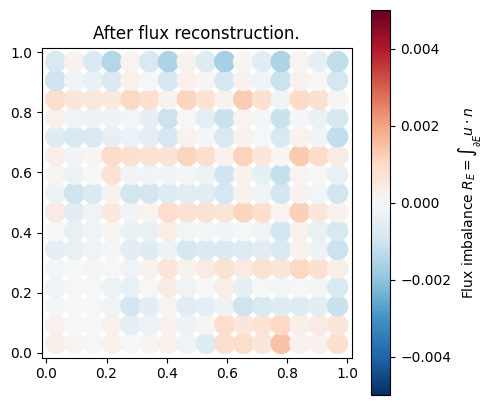

In [115]:
fig2, ax2 = plt.subplots(figsize=(5, 5))

R_local = R_from_facet  # <- use facet-based residual

dx_points = ax2.transData.transform((1,0))[0] - ax2.transData.transform((0,0))[0]
dy_points = ax2.transData.transform((0,1))[1] - ax2.transData.transform((0,0))[1]
r_points = h/2 * 0.6 * (dx_points + dy_points)

s_val = r_points**2

sc = ax2.scatter(
    cell_cent[:, 0],
    cell_cent[:, 1],
    c=R_local,
    s=s_val,
    cmap="RdBu_r",
    vmin=-0.005, vmax=0.005
)
ax2.set_aspect('equal')
ax2.set_title("After flux reconstruction.")
fig2.colorbar(sc, ax=ax2, label=r"Flux imbalance $R_E = \int_{\partial E} u\cdot n$")

fig2.show()


In [117]:
np.max(abs(R_local))

np.float64(0.001679572018615063)

In [57]:
from dolfinx import mesh
import numpy as np

tdim = msh.topology.dim
fdim = tdim - 1

msh.topology.create_connectivity(tdim, fdim)
c2f = msh.topology.connectivity(tdim, fdim)

num_cells  = msh.topology.index_map(tdim).size_local
# number of facets per cell (for simplices: 3 in 2D, 4 in 3D)
num_facets_per_cell = len(c2f.links(0))

# outward flux per (cell, local facet)
F_out_cell = np.zeros((num_cells, num_facets_per_cell), dtype=float)

for c in range(num_cells):
    cell_facets = c2f.links(c)  # global facet indices for this cell

    for lf, f in enumerate(cell_facets):
        n_hat  = face_norm[f]
        A_f    = face_area[f]
        F_face = facet_flux[f]
        face_c = face_cent[f]

        vec_cf  = face_c - cell_cent[c]
        sign_cf = np.sign(np.dot(n_hat, vec_cf))
        if sign_cf == 0:
            # degenerate case, pick a convention
            sign_cf = 1.0

        F_out = sign_cf * F_face   # "total flux leaving cell c" through facet f
        F_out_cell[c, lf] = F_out


In [60]:
from dolfinx import mesh, geometry
import numpy as np

# Dimensions
tdim_O = msh.topology.dim  # should be 3
tdim_G = g_msh.topology.dim  # should be 1

# Build connectivity on Gamma: cell -> vertices
g_msh.topology.create_connectivity(tdim_G, 0)
conn_G = g_msh.topology.connectivity(tdim_G, 0)

x_G = g_msh.geometry.x  # coordinates of Gamma vertices

num_gamma_cells = g_msh.topology.index_map(tdim_G).size_local

# Bounding box tree of the bulk mesh
bbt_bulk = geometry.bb_tree(msh, tdim_O)

# Array: for each Gamma cell, the index of the containing Omega cell
gamma_to_omega = np.full(num_gamma_cells, -1, dtype=np.int32)

# 1) Collect all x_gamma (midpoints of gamma cells)
gdim = x_G.shape[1]  # spatial dimension
x_gamma = np.empty((num_gamma_cells, gdim), dtype=x_G.dtype)

for c in range(num_gamma_cells):
    # get vertices of 1D cell c
    verts = conn_G.links(c)
    # compute midpoint of the line segment in physical space
    x_mid = x_G[verts].mean(axis=0)
    x_gamma[c] = x_mid

# 2) Find collisions in bulk mesh for all x_gamma at once
# candidates on COARSE mesh
cands = geometry.compute_collisions_points(bbt_bulk, x_gamma)
# filter to true hits
hits = geometry.compute_colliding_cells(msh, cands, x_gamma)

# 3) Map each gamma cell to first containing bulk cell (if any)
for c in range(num_gamma_cells):
    li = hits.links(c)  # cells that contain x_gamma[c]
    if len(li) > 0:     # i.e. not "empty"
        gamma_to_omega[c] = li[0]
    else:
        # no containing cell found – debug or handle separately if needed
        pass



In [ ]:
from dolfinx import mesh

p_global = p.x.array
loc_pm = {}
for k in range(num_cells):
    print((k)/num_cells,end="\r")
    cell_indices = np.array([k], dtype=np.int32)
    # Omega_sub, cell_map_O, facet_map_O = mesh.create_submesh(Omega, tdim_O, cell_indices)[0:3]
    Omega_sub, cell_map_O, *rest = mesh.create_submesh(msh, tdim_O, cell_indices)

    # Bounding box of this bulk cell
    coords_O = Omega_sub.geometry.x
    xmin_s, xmax_s = coords_O[:, 0].min(), coords_O[:, 0].max()
    ymin_s, ymax_s = coords_O[:, 1].min(), coords_O[:, 1].max()
    if coords_O.shape[1] == 3:
        zmin_s, zmax_s = coords_O[:, 2].min(), coords_O[:, 2].max()
    else:
        zmin_s = zmax_s = 0.0  # ignored in 2D

    # Small tolerance based on cell size
    tol = 1e-10 * np.max(np.ptp(coords_O, axis=0))

    # ---- 2) Gamma cells whose midpoint is mapped to this bulk cell ----
    cand_gamma_cells = np.where(gamma_to_omega == k)[0].astype(np.int32)

    # ---- 3) KEEP only those whose *all vertices* lie in this bbox ----
    clipped_gamma_cells = []
    for gc in cand_gamma_cells:
        verts = conn_G.links(gc)
        pts = x_G[verts]  # shape (n_verts, gdim)

        inside_x = (pts[:, 0].min() >= xmin_s - tol) and (pts[:, 0].max() <= xmax_s + tol)
        inside_y = (pts[:, 1].min() >= ymin_s - tol) and (pts[:, 1].max() <= ymax_s + tol)

        if coords_O.shape[1] == 3:
            inside_z = (pts[:, 2].min() >= zmin_s - tol) and (pts[:, 2].max() <= zmax_s + tol)
        else:
            inside_z = True

        if inside_x and inside_y and inside_z:
            clipped_gamma_cells.append(gc)

    clipped_gamma_cells = np.array(clipped_gamma_cells, dtype=np.int32)

    # ---- 4) Build Gamma_sub from the *clipped* list ----
    if clipped_gamma_cells.size > 0:
        Gamma_sub, cell_map_G, facet_map_G = mesh.create_submesh(
            g_msh, tdim_G, clipped_gamma_cells
        )[0:3]
    else:
        Gamma_sub = None
    
    # gamma_cells_k = np.where(gamma_to_omega == k)[0].astype(np.int32)

    # if gamma_cells_k.size > 0:
    #     Gamma_sub, cell_map_G, facet_map_G = mesh.create_submesh(
    #         Gamma, tdim_G, gamma_cells_k
    #     )[0:3]
    # else:
    #     # No interface in this bulk cell – your local problem is purely bulk
    #     Gamma_sub = None

    order = 1

    V_m_sub = fem.functionspace(Omega_sub, ("Lagrange", order))

    if Gamma_sub is not None:
        coords_G = Gamma_sub.geometry.x

        # distances from each Γ-sub vertex to each side of the bbox
        d_left   = coords_G[:, 0] - xmin_s
        d_right  = xmax_s - coords_G[:, 0]
        d_bottom = coords_G[:, 1] - ymin_s
        d_top    = ymax_s - coords_G[:, 1]

        if coords_O.shape[1] == 3:
            d_front = coords_G[:, 2] - zmin_s
            d_back  = zmax_s - coords_G[:, 2]
            d_all = np.vstack([d_left, d_right, d_bottom, d_top, d_front, d_back])
        else:
            d_all = np.vstack([d_left, d_right, d_bottom, d_top])

        # minimal distance from Γ to any face of the cell
        d_min = np.min(d_all)

        # safety: if Γ touches the boundary, we can't build a tube
        if d_min <= 0:
            # this cell’s fracture is too close to/ on the boundary.
            # Option 1: treat as pure bulk here
            Gamma_sub = None
            # (or: skip this cell, or enlarge domain…)
        else:
            # global choice R (your old value)
            R_global = np.min([0.01, h/4])

    if Gamma_sub is not None:
        # ---------- CASE 1: cell WITH fracture ----------
        V_f_sub = fem.functionspace(Gamma_sub, ("Lagrange", order))
        V_l_sub = fem.functionspace(Gamma_sub, ("Lagrange", order))
        W_sub   = ufl.MixedFunctionSpace(V_m_sub, V_f_sub, V_l_sub)
        # V_m_sub = W_sub.sub(0)  # corresponds to V_m_sub
        # V_f_sub = W_sub.sub(1)  # corresponds to V_f_sub

        phi_s, psi_s, mu_s   = ufl.TestFunctions(W_sub)
        p_m_s, p_f_s, lmbd_s = ufl.TrialFunctions(W_sub)

        dx_sub = ufl.Measure("dx", domain=Omega_sub)
        ds_sub = ufl.Measure("dx", domain=Gamma_sub)

        from fenicsx_ii import Average, Circle
        import basix.ufl

        R = min(R_global, 0.5 * d_min)
        q_degree = 16   # quadrature degree along the circle (tune)
        restriction_trial_sub = Circle(Gamma_sub, R, degree=q_degree)
        restriction_test_sub  = Circle(Gamma_sub, R, degree=q_degree)

        q_el_sub = basix.ufl.quadrature_element(
            Gamma_sub.basix_cell(), value_shape=(), degree=q_degree
        )
        Rs_sub = fem.functionspace(Gamma_sub, q_el_sub)

        avg_pm_s  = Average(p_m_s,  restriction_trial_sub, Rs_sub)
        avg_phi_s = Average(phi_s, restriction_test_sub,  Rs_sub)

        f_m_s = fem.Constant(Omega_sub, 0.0)
        f_f_s = fem.Constant(Gamma_sub, 0.0)
        k_m_s = fem.Constant(Omega_sub, k_values)
        k_f_s = fem.Constant(Gamma_sub, 1.0)

        # bulk
        a_m0_s = ufl.inner(k_m_s * ufl.grad(p_m_s), ufl.grad(phi_s)) * dx_sub
        a_m1_s = - lmbd_s * avg_phi_s * ds_sub
        a_m_s  = a_m0_s + a_m1_s
        L_m_s  = f_m_s * phi_s * dx_sub

        # fracture
        a_f0_s = ufl.inner(k_f_s * ufl.grad(p_f_s), ufl.grad(psi_s)) * ds_sub
        a_f1_s = lmbd_s * psi_s * ds_sub
        a_f_s  = a_f0_s + a_f1_s
        L_f_s  = f_f_s * psi_s * ds_sub

        # multiplier
        a_l0_s = avg_pm_s * mu_s * ds_sub
        a_l1_s = -p_f_s * mu_s * ds_sub
        a_l_s  = a_l0_s + a_l1_s
        L_l_s  = fem.Constant(Gamma_sub, 0.0) * mu_s * ds_sub

        a_gamma_s = a_f_s + a_l_s
        L_gamma_s = L_f_s + L_l_s

        a_s = a_m_s + a_gamma_s
        L_s = L_m_s + L_gamma_s

    else:
        # ---------- CASE 2: cell WITHOUT fracture ----------
        # Only bulk unknown p_m_s, standard scalar Poisson-type local problem

        W_sub = V_m_sub  # just bulk space

        phi_s = ufl.TestFunction(W_sub)
        p_m_s = ufl.TrialFunction(W_sub)

        dx_sub = ufl.Measure("dx", domain=Omega_sub)

        f_m_s = fem.Constant(Omega_sub, 0.0)
        k_m_s = fem.Constant(Omega_sub, k_values)

        a_s = ufl.inner(k_m_s * ufl.grad(p_m_s), ufl.grad(phi_s)) * dx_sub
        L_s = f_m_s * phi_s * dx_sub

        # No Gamma terms, no p_f_s, no lmbd_s
    # re-use global xmin, xmax and tol
    left_dofs_sub = fem.locate_dofs_geometrical(
        V_m_sub, lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_sub = fem.locate_dofs_geometrical(
        V_m_sub, lambda x: np.isclose(x[0], xmax, atol=tol)
    )

    # possibly empty if the element is interior
    all_dofs_sub = np.unique(np.concatenate([left_dofs_sub, right_dofs_sub])) \
        if (left_dofs_sub.size + right_dofs_sub.size) > 0 else np.array([], dtype=np.int32)
    
    bc_m_list = []

    if all_dofs_sub.size > 0:
        p_m_bc_sub = fem.Function(V_m_sub)
        # default 0 everywhere
        p_m_bc_sub.x.array[:] = 0.0

        # set side-dependent values, same as global: 1 on left, 4 on right
        p_m_bc_sub.x.array[left_dofs_sub] = 1.0
        p_m_bc_sub.x.array[right_dofs_sub] = 4.0

        bc_pm_sub = fem.dirichletbc(p_m_bc_sub, all_dofs_sub)
        bc_m_list.append(bc_pm_sub)

    bc_f_list = []

    if Gamma_sub is not None:
        tol_g = 1e-10 * np.max(np.ptp(g_msh.geometry.x, axis=0))  # or recompute from Gamma_sub

        tip1_dofs_sub = fem.locate_dofs_geometrical(
            V_f_sub,
            lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                                    np.isclose(x[1], y_start, atol=tol_g))
        )
        tip2_dofs_sub = fem.locate_dofs_geometrical(
            V_f_sub,
            lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                                    np.isclose(x[1], y_end, atol=tol_g))
        )

        both_tips_sub = np.unique(np.concatenate([tip1_dofs_sub, tip2_dofs_sub])) \
            if (tip1_dofs_sub.size + tip2_dofs_sub.size) > 0 else np.array([], dtype=np.int32)

        if both_tips_sub.size > 0:
            pf_fun_sub = fem.Function(V_f_sub)
            pf_fun_sub.x.array[:] = 0.0
            pf_fun_sub.x.array[tip1_dofs_sub] = 1.0
            pf_fun_sub.x.array[tip2_dofs_sub] = 4.0

            bc_pf_sub = fem.dirichletbc(pf_fun_sub, both_tips_sub)
            bc_f_list.append(bc_pf_sub)

    # --- 1. Global: classify facets of cell k as Dirichlet or Neumann ---

    tdim = msh.topology.dim
    fdim = tdim - 1

    msh.topology.create_connectivity(tdim, fdim)
    msh.topology.create_connectivity(fdim, 0)

    c2f = msh.topology.connectivity(tdim, fdim)
    f2v = msh.topology.connectivity(fdim, 0)
    x_global = msh.geometry.x

    facets_of_k = c2f.links(k)  # global facet indices for cell k

    is_dirichlet_facet = np.zeros(facets_of_k.size, dtype=bool)

    for i, f in enumerate(facets_of_k):
        verts = f2v.links(f)
        coords_f = x_global[verts]

        on_left  = np.all(np.isclose(coords_f[:, 0], xmin, atol=tol))
        on_right = np.all(np.isclose(coords_f[:, 0], xmax, atol=tol))

        is_dirichlet_facet[i] = on_left or on_right

    # global Neumann facet ids
    neumann_facets_k = facets_of_k[~is_dirichlet_facet]
    
    from dolfinx.mesh import meshtags
    # --- 2. Local: find which local facets are Neumann ---

    fdim_sub = Omega_sub.topology.dim - 1
    Omega_sub.topology.create_connectivity(Omega_sub.topology.dim, fdim_sub)

    c2f_sub = Omega_sub.topology.connectivity(Omega_sub.topology.dim, fdim_sub)

    facets_local = c2f_sub.links(0)               # local facet indices [0,1,...]
    num_local_facets = facets_local.size
    local_facets = np.arange(num_local_facets, dtype=np.int32)

    # We assume local facet ordering matches global cell's local ordering:
    # facets_of_k[lf] is the global facet for local facet lf
    global_facets_for_local = facets_of_k        # same length/order as facets_local

    # mark local facets that correspond to global Neumann facets
    is_neumann_local = np.isin(global_facets_for_local, neumann_facets_k)
    neumann_local_facets = local_facets[is_neumann_local]

    if neumann_local_facets.size > 0:
        # Tag Neumann facets in the submesh
        tags_neu = np.arange(1, neumann_local_facets.size + 1, dtype=np.int32)

        facet_markers_sub = meshtags(
            Omega_sub,
            fdim_sub,
            neumann_local_facets,
            tags_neu
        )

        dsN_sub = ufl.Measure("ds", domain=Omega_sub, subdomain_data=facet_markers_sub)

        # Add Neumann flux per facet
        for idx, lf in enumerate(neumann_local_facets):
            tag   = tags_neu[idx]
            f_glob = global_facets_for_local[lf]   # global facet index
            F_out  = F_out_cell[k, lf]             # outward flux for cell k through facet lf
            A_f    = face_area[f_glob]

            # If F_out is total flux (integral over facet):
            # g_face = F_out / A_f
            # If F_out already is flux density k∇p·n_out:
            g_face = F_out

            # phi_s is the bulk test function
            L_s -= g_face * phi_s * dsN_sub(tag)

    bcs_local = bc_m_list + bc_f_list

    
    from dolfinx.fem.petsc import LinearProblem as DX_LinearProblem

    petsc_options = {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    }

    if Gamma_sub is not None:
        # --- WITH FRACTURE: use fenicsx_ii.LinearProblem on mixed space W_sub ---
        from fenicsx_ii import LinearProblem as II_LinearProblem

        # ---------------------------------------------------
        # PURE NEUMANN CELL (with fracture): no local Dirichlet BCs
        # Adjust condition if you also track bc_f_list etc.
        # ---------------------------------------------------
        pure_neumann_cell = (len(bcs_local) == 0)

        if pure_neumann_cell:
            # We'll anchor a single MATRIX-pressure dof (component 0) using p_global
            # Reuse the same machinery as in the "WITHOUT FRACTURE" branch

            # Local dof coordinates on the submesh (matrix space)
            x_sub = V_m_sub.tabulate_dof_coordinates().reshape(-1, gdim)

            # Global dof coordinates (parent matrix space)
            x_glob = V.tabulate_dof_coordinates().reshape(-1, gdim)

            index_map_sub = V_m_sub.dofmap.index_map
            bs_sub = V_m_sub.dofmap.index_map_bs
            num_local_dofs = index_map_sub.size_local * bs_sub

            # candidate local dofs in the matrix subspace
            local_dofs = np.arange(num_local_dofs, dtype=np.int32)

            p_m_sub = p_f_sub = lmbd_sub = None
            success = False
            bcs_trial = list(bcs_local)

            for j in local_dofs:
                try:
                    # Try to solve the MIXED problem with current trial BCs
                    problem_trial = II_LinearProblem(
                        a_s,
                        L_s,
                        bcs=bcs_trial,
                        petsc_options_prefix="coupled_poisson",
                        petsc_options=petsc_options,
                    )
                    p_m_candidate, p_f_candidate, lmbd_candidate = problem_trial.solve()

                    # If we get here, KSP converged
                    p_m_sub, p_f_sub, lmbd_sub = (
                        p_m_candidate,
                        p_f_candidate,
                        lmbd_candidate,
                    )
                    success = True
                    break

                except:
                    # System still singular / not converged: try anchoring another local dof

                    # ---- map local matrix dof j to closest global matrix dof ----
                    x_anchor = x_sub[j]
                    dist = np.linalg.norm(x_glob - x_anchor, axis=1)
                    gdof = int(dist.argmin())

                    u_anchor = float(p_global[gdof])

                    # build Dirichlet BC on this single local MATRIX dof j
                    anchor_dof_sub = np.array([j], dtype=np.int32)

                    # BC is on the matrix-pressure subspace of the MIXED space W_sub
                    bc_anchor = fem.dirichletbc(u_anchor, anchor_dof_sub, V_m_sub)

                    bcs_trial = list(bcs_local) + [bc_anchor]
                    continue

            if not success:
                raise RuntimeError(
                    f"Could not find an anchor dof that yields a non-singular local mixed system for cell {k}"
                )

        else:
            # Standard mixed solve with fracture: no anchoring needed
            problem = II_LinearProblem(
                a_s,
                L_s,
                petsc_options_prefix="coupled_poisson",
                petsc_options=petsc_options,
                bcs=bcs_local,
            )
            p_m_sub, p_f_sub, lmbd_sub = problem.solve()

    else:
        # --- WITHOUT FRACTURE: standard dolfinx LinearProblem on V_m_sub ---

        # ---------------------------------------------------
        # PURE NEUMANN CELL: need to ANCHOR one local dof
        # using global solution p_global, and try until success
        # ---------------------------------------------------

        # Local dof coordinates (submesh)
        pure_neumann_cell = (Gamma_sub is None) and (len(bc_m_list) == 0)

        if pure_neumann_cell:
            x_sub = V_m_sub.tabulate_dof_coordinates().reshape(-1, gdim)

            # Global dof coordinates (parent space)
            x_glob = V.tabulate_dof_coordinates().reshape(-1, gdim)

            index_map_sub = V_m_sub.dofmap.index_map
            bs_sub = V_m_sub.dofmap.index_map_bs
            num_local_dofs = index_map_sub.size_local * bs_sub

            # candidate local dofs
            local_dofs = np.arange(num_local_dofs, dtype=np.int32)

            p_m_sub = None
            success = False
            bcs_trial = bcs_local
            for j in local_dofs:

                try:
                    # Try to solve with this anchor
                    problem_trial = DX_LinearProblem(
                        a_s,
                        L_s,
                        bcs=bcs_trial,
                        petsc_options=petsc_options,
                        petsc_options_prefix="coupled_poisson"
                    )
                    p_m_sub_candidate = problem_trial.solve()
                    # If we get here without an exception, KSP converged
                    p_m_sub = p_m_sub_candidate
                    success = True
                    break

                except:
                    # Typically from PETSc if system is singular or KSP doesn't converge
                    # Try next local dof
                    # ---- map local dof j to closest global dof ----
                    x_anchor = x_sub[j]
                    dist = np.linalg.norm(x_glob - x_anchor, axis=1)
                    gdof = int(dist.argmin())

                    u_anchor = float(p_global[gdof])

                    # build a scalar-valued Dirichlet BC on this single local dof j
                    anchor_dof_sub = np.array([j], dtype=np.int32)
                    bc_anchor = fem.dirichletbc(u_anchor, anchor_dof_sub, V_m_sub)

                    bcs_trial = bcs_local + [bc_anchor]
                    continue

            if not success:
                raise RuntimeError(
                    f"Could not find an anchor dof that yields a non-singular local system for cell {k}"
                )
        else:
            problem = DX_LinearProblem(
                a_s,
                L_s,
                bcs=bcs_local,
                petsc_options=petsc_options,
                petsc_options_prefix="coupled_poisson"
            )
            p_m_sub = problem.solve()


    loc_pm[k] = p_m_sub


In [73]:
from dolfinx import fem, mesh as dmesh
import numpy as np

order = 1  # same as before

# Global bulk space
V = fem.functionspace(msh, ("Lagrange", order))
gdim = msh.geometry.x.shape[1]

# Global dof coordinates
x_glob = V.tabulate_dof_coordinates().reshape(-1, gdim)

index_map = V.dofmap.index_map
bs = V.dofmap.index_map_bs
num_glob_dofs = index_map.size_local * bs

p_sum   = np.zeros(num_glob_dofs, dtype=float)
p_count = np.zeros(num_glob_dofs, dtype=np.int32)


In [74]:
tdim_O = msh.topology.dim

for k, p_m_sub in loc_pm.items():
    # Rebuild the same submesh you used when solving
    cell_indices = np.array([k], dtype=np.int32)
    Omega_sub, cell_map_O, *rest = dmesh.create_submesh(msh, tdim_O, cell_indices)

    # Local space (bulk only)
    V_m_sub = fem.functionspace(Omega_sub, ("Lagrange", order))

    # Local dof coordinates and local solution values
    x_sub = V_m_sub.tabulate_dof_coordinates().reshape(-1, gdim)
    p_loc = p_m_sub.x.array

    # Map each local dof to nearest global dof and accumulate
    for j in range(p_loc.size):
        xj = x_sub[j]

        # nearest global dof (for P1 this should be exact up to roundoff)
        dist2 = np.sum((x_glob - xj)**2, axis=1)
        gdof = int(np.argmin(dist2))

        p_sum[gdof]   += p_loc[j]
        p_count[gdof] += 1

p_m_global = fem.Function(V)

mask = p_count > 0
p_m_global.x.array[:] = 0.0
p_m_global.x.array[mask] = p_sum[mask] / p_count[mask]

In [75]:
from dolfinx.io import XDMFFile
from mpi4py import MPI

with XDMFFile(MPI.COMM_WORLD, "p_postprocessed.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(p_m_global)


In [45]:
import numpy as np

coords_O = Omega_sub.geometry.x  # shape (N_O, gdim)
coords_G = Gamma_sub.geometry.x  # shape (N_G, gdim)

print("Omega_sub bbox:")
print("  x:", coords_O[:, 0].min(), "→", coords_O[:, 0].max())
print("  y:", coords_O[:, 1].min(), "→", coords_O[:, 1].max())
if coords_O.shape[1] == 3:
    print("  z:", coords_O[:, 2].min(), "→", coords_O[:, 2].max())

print("\nGamma_sub bbox:")
print("  x:", coords_G[:, 0].min(), "→", coords_G[:, 0].max())
print("  y:", coords_G[:, 1].min(), "→", coords_G[:, 1].max())
if coords_G.shape[1] == 3:
    print("  z:", coords_G[:, 2].min(), "→", coords_G[:, 2].max())

Omega_sub bbox:
  x: 0.25 → 0.265625
  y: 0.015625 → 0.03125
  z: 0.0 → 0.02

Gamma_sub bbox:
  x: 0.25354609929078015 → 0.26063829787234044
  y: 0.01695035460992908 → 0.030851063829787237
  z: 0.01 → 0.01


In [33]:
neumann_local_facets

array([0, 1, 2, 3, 4, 5], dtype=int32)

OLD CODE

In [7]:
msh.topology.create_connectivity(tdim, 0)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_cells = msh.topology.index_map(tdim).size_local
cell_cent = np.zeros((num_cells, gdim), dtype=np.float64)

for c in range(num_cells):
    verts = cell_to_vertex.links(c)
    cell_cent[c] = np.mean(x[verts], axis=0)

In [23]:
ndofs = V.dofmap.index_map.size_local * V.dofmap.index_map_bs

is_dirichlet_dof = np.zeros(ndofs, dtype=bool)
is_dirichlet_dof[all_dofs] = True

p_global = p.x.array  # global solution values at dofs

p_trial = ufl.TrialFunction(V)
p_test  = ufl.TestFunction(V)
a_form = ufl.inner(k_m * ufl.grad(p_trial), ufl.grad(p_test)) * dx

import numpy as np
from petsc4py import PETSc
from dolfinx import mesh

tdim = msh.topology.dim

# Connectivity: cells <-> facets, facets <-> vertices, cells <-> vertices
msh.topology.create_connectivity(tdim, 0)
msh.topology.create_connectivity(tdim, tdim-1)
msh.topology.create_connectivity(tdim-1, 0)

cell_to_vertex = msh.topology.connectivity(tdim, 0)
cell_to_facet  = msh.topology.connectivity(tdim, tdim-1)
facet_to_vertex = msh.topology.connectivity(tdim-1, 0)

x = msh.geometry.x

num_cells = msh.topology.index_map(tdim).size_local

# Store reconstructed local values per cell (variable number of dofs per cell, 
# but for CG1 simplex/hex it's number of vertices per cell)
# To keep it simple, we'll just store in a dict: cell -> (local_dofs, u_K)
p_local_cells = {}

def local_diffusion_matrix_hex(X, K_tensor):
    """
    X: (8, 3) coordinates of hexahedron vertices, ordered consistently
    with standard Q1 reference cube node ordering.
    K_tensor: (3,3) permeability tensor.
    Uses 2x2x2 Gauss quadrature on reference cube [-1,1]^3.
    """
    # Reference node positions (ξ_i, η_i, ζ_i) for Q1 hex
    ref_nodes = np.array([
        [-1, -1, -1],
        [ 1, -1, -1],
        [-1,  1, -1],
        [ 1,  1, -1],
        [-1, -1,  1],
        [ 1, -1,  1],
        [-1,  1,  1],
        [ 1,  1,  1],
    ], dtype=float)

    # 1D 2-point Gauss rule on [-1,1]
    a = 1.0 / np.sqrt(3.0)
    gp_1d = np.array([-a, a], dtype=float)
    gw_1d = np.array([1.0, 1.0], dtype=float)

    # Build 3D tensor-product quadrature
    quad_points = []
    quad_weights = []
    for i, xi in enumerate(gp_1d):
        for j, eta in enumerate(gp_1d):
            for k, zeta in enumerate(gp_1d):
                quad_points.append([xi, eta, zeta])
                quad_weights.append(gw_1d[i] * gw_1d[j] * gw_1d[k])

    quad_points = np.array(quad_points)   # shape (8,3)
    quad_weights = np.array(quad_weights) # length 8

    nn = 8  # number of Q1 nodes
    A_K = np.zeros((nn, nn), dtype=float)

    # Loop over quadrature points
    for q in range(len(quad_points)):
        xi, eta, zeta = quad_points[q]
        wq = quad_weights[q]

        # Shape function gradients in reference space at (xi,eta,zeta)
        # N_i(ξ,η,ζ) = 1/8 (1 + ξ ξ_i)(1 + η η_i)(1 + ζ ζ_i)
        # ∂N_i/∂ξ = 1/8 ξ_i (1 + η η_i)(1 + ζ ζ_i), etc.
        grad_hat = np.zeros((nn, 3), dtype=float)
        for i_node in range(nn):
            xi_i, eta_i, zeta_i = ref_nodes[i_node]

            dN_dxi =  0.125 * xi_i   * (1.0 + eta * eta_i) * (1.0 + zeta * zeta_i)
            dN_deta = 0.125 * eta_i  * (1.0 + xi  * xi_i)  * (1.0 + zeta * zeta_i)
            dN_dzeta= 0.125 * zeta_i * (1.0 + xi  * xi_i)  * (1.0 + eta  * eta_i)

            grad_hat[i_node, :] = [dN_dxi, dN_deta, dN_dzeta]

        # Jacobian J = ∑_i X_i ⊗ ∇_hat N_i
        J = np.zeros((3, 3), dtype=float)
        for i_node in range(nn):
            # X[i_node,:] shape (3,)
            # grad_hat[i_node,:] shape (3,)
            J[:, 0] += X[i_node, :] * grad_hat[i_node, 0]
            J[:, 1] += X[i_node, :] * grad_hat[i_node, 1]
            J[:, 2] += X[i_node, :] * grad_hat[i_node, 2]

        detJ = np.linalg.det(J)
        if detJ <= 0:
            # Degenerate or inverted element; skip or raise
            continue

        invJT = np.linalg.inv(J).T  # J^{-T}

        # Physical gradients ∇φ_i = J^{-T} ∇_hat φ_i
        grad_phi = grad_hat @ invJT  # shape (nn,3)

        # Contribute to A_K
        for i in range(nn):
            Ki = K_tensor @ grad_phi[i]
            for j in range(nn):
                A_K[i, j] += wq * detJ * (grad_phi[j] @ Ki)

    return A_K


def local_diffusion_matrix(X, K_tensor):
    """
    X: (n_vertex, 3) coords of the cell's vertices.
       n_vertex = 4 for tetra, 8 for hex.
    K_tensor: (3,3)
    cell_type: dolfinx.mesh.CellType
    """
    return local_diffusion_matrix_hex(X, K_tensor)

import numpy as np
from dolfinx.mesh import CellType


def eval_local_basis_on_cell(
    c: int,
    x_phys: np.ndarray,
    Omega,
    cell_to_vertex,
) -> np.ndarray:
    """
    Evaluate bulk CG1/Q1 basis functions {phi_i} on a given cell `c` at a
    physical point x_phys.

    Parameters
    ----------
    c : int
        Bulk cell index.
    x_phys : np.ndarray
        Physical point, shape (3,) for 3D, or (2,) for 2D.
    Omega : dolfinx.mesh.Mesh
        Bulk mesh.
    cell_to_vertex : dolfinx.cpp.graph.AdjacencyList_int32
        Connectivity: cell -> vertex indices.
    cell_type : dolfinx.mesh.CellType
        Type of bulk cells (tetrahedron or hexahedron).

    Returns
    -------
    phi : np.ndarray
        Values of the local basis functions on cell `c` at x_phys.
        Length = number of vertices in the cell (4 for tet, 8 for hex).
    """
    x = Omega.geometry.x
    gdim = Omega.geometry.dim

    x_phys = np.asarray(x_phys, dtype=float)
    assert x_phys.shape == (gdim,)

    cell_vertices = cell_to_vertex.links(c)
    Xc = x[cell_vertices]  # shape (n_vertex, gdim)
    n_vertex = Xc.shape[0]

    # ---- Q1 hex: Newton iteration to get (xi,eta,zeta) in ref cube ----
    assert n_vertex == 8

    # Reference node positions (ξ_i, η_i, ζ_i)
    ref_nodes = np.array([
        [-1, -1, -1],
        [ 1, -1, -1],
        [-1,  1, -1],
        [ 1,  1, -1],
        [-1, -1,  1],
        [ 1, -1,  1],
        [-1,  1,  1],
        [ 1,  1,  1],
    ], dtype=float)

    def shape_and_grad_ref(xi, eta, zeta):
        """
        Q1 shape funcs and their grads in reference coords at (xi,eta,zeta).
        Returns:
            N : (8,) shape function values
            grad_hat : (8,3) gradients wrt (xi,eta,zeta)
        """
        N = np.zeros(8, dtype=float)
        grad_hat = np.zeros((8, 3), dtype=float)
        for i in range(8):
            xi_i, eta_i, zeta_i = ref_nodes[i]
            # shape value
            N[i] = 0.125 * (1.0 + xi * xi_i) * (1.0 + eta * eta_i) * (1.0 + zeta * zeta_i)
            # partial derivatives
            dN_dxi =  0.125 * xi_i   * (1.0 + eta * eta_i) * (1.0 + zeta * zeta_i)
            dN_deta = 0.125 * eta_i  * (1.0 + xi  * xi_i)  * (1.0 + zeta * zeta_i)
            dN_dzeta= 0.125 * zeta_i * (1.0 + xi  * xi_i)  * (1.0 + eta  * eta_i)
            grad_hat[i, :] = [dN_dxi, dN_deta, dN_dzeta]
        return N, grad_hat

    # Newton iteration in reference space, starting from center (0,0,0)
    xi_eta_zeta = np.zeros(3, dtype=float)

    for _ in range(8):  # up to 8 iterations (overkill but cheap)
        xi, eta, zeta = xi_eta_zeta
        N, grad_hat = shape_and_grad_ref(xi, eta, zeta)

        # x_ref(ξ,η,ζ) in physical coordinates
        x_map = np.zeros(gdim, dtype=float)
        for i in range(8):
            x_map += N[i] * Xc[i, :]

        # residual in physical coords
        r = x_map - x_phys

        # check convergence
        if np.linalg.norm(r) < 1e-12:
            break

        # Jacobian J = ∂x/∂(ξ,η,ζ) = Σ_i X_i ⊗ ∇_hat N_i
        J = np.zeros((gdim, 3), dtype=float)
        for i in range(8):
            # Xc[i,:] shape (gdim,), grad_hat[i,:] shape (3,)
            J[:, 0] += Xc[i, :] * grad_hat[i, 0]
            J[:, 1] += Xc[i, :] * grad_hat[i, 1]
            J[:, 2] += Xc[i, :] * grad_hat[i, 2]

        # Solve J * dξ = -r
        dxi = np.linalg.solve(J, -r)
        xi_eta_zeta += dxi

        if np.linalg.norm(dxi) < 1e-12:
            break

    # Final shape values at converged (ξ,η,ζ)
    xi, eta, zeta = xi_eta_zeta
    N, _ = shape_and_grad_ref(xi, eta, zeta)

    return N

import numpy as np
from dolfinx import geometry

tdim_bulk = msh.topology.dim          # 2 or 3
tdim_gamma = Gamma.topology.dim         # should be 1
gdim = msh.geometry.dim               # geometric dimension (2 or 3)

# Bulk cells
num_bulk_cells = Omega.topology.index_map(tdim_bulk).size_local

# Gamma cells
Gamma.topology.create_connectivity(tdim_gamma, 0)  # cell -> vertex on Gamma
gamma_cell_to_vertex = Gamma.topology.connectivity(tdim_gamma, 0)
num_gamma_cells = Gamma.topology.index_map(tdim_gamma).size_local

def build_gamma_cells_in_bulk(Omega, Gamma):
    """
    Build a mapping bulk_cell -> list of gamma_cells that lie inside it.

    Parameters
    ----------
    Omega : dolfinx.mesh.Mesh
        Bulk mesh (2D or 3D).
    Gamma : dolfinx.mesh.Mesh
        1D interface mesh (e.g. fracture / line), embedded in the same
        geometric dimension as Omega.

    Returns
    -------
    gamma_cells_in_bulk_cell : dict[int, list[int]]
        Dictionary mapping each bulk cell index c (0..num_bulk_cells-1)
        to a list of gamma cell indices g such that the midpoint of
        gamma cell g is inside (or at least in the bounding box of)
        bulk cell c.
    """

    # --- Basic dimensions and connectivity ---


    # --- Build midpoints of all gamma cells ---
    Xg = Gamma.geometry.x

    # midpoints has shape (gdim, num_gamma_cells) as required by dolfinx.geometry
    midpoints = np.zeros((gdim, num_gamma_cells), dtype=np.float64)

    for g in range(num_gamma_cells):
        verts = gamma_cell_to_vertex.links(g)  # endpoints of segment g
        coords = Xg[verts]                    # shape (2, gdim)
        mid = coords.mean(axis=0)             # midpoint in physical coords
        midpoints[:, g] = mid

    # --- Build bounding box tree for bulk cells ---
    # bbt_bulk = geometry.BoundingBoxTree(Omega, tdim_bulk)
    bbt_bulk = geometry.bb_tree(msh, tdim_bulk)

    # Compute candidate bulk cells for each midpoint
    # colliding_cells is a list-like object; colliding_cells[g] is an array
    # of bulk cell indices whose bounding boxes contain the g-th point.
    cands = geometry.compute_collisions_points(bbt_bulk, midpoints.T)
    colliding_cells = geometry.compute_colliding_cells(msh, cands, midpoints.T)
    # colliding_cells = geometry.compute_colliding_cells(bbt_bulk, midpoints)

    # --- Initialize result dict ---
    gamma_cells_in_bulk_cell = {c: [] for c in range(num_bulk_cells)}

    # --- Assign each γ-cell to a bulk cell using hits.links(i) ---
    for g in range(num_gamma_cells):
        li = colliding_cells.links(g)   # list of bulk cells intersecting midpoint g
        if len(li) == 0:
            # midpoint lies outside Ω (or small numerical miss) — skip
            continue

        # pick first owning bulk cell (as in standard FEniCSx usage)
        c = int(li[0])
        gamma_cells_in_bulk_cell[c].append(g)


    return gamma_cells_in_bulk_cell


# Pseudocode: for each gamma cell, find which bulk cell it lies in
gamma_cells_in_bulk_cell = build_gamma_cells_in_bulk(Omega, Gamma)

for c in range(num_cells):
    # Global dofs for this cell in V
    local_dofs = V.dofmap.cell_dofs(c)
    nc = len(local_dofs)
    cell_vertices = cell_to_vertex.links(c)  # global vertex indices
    Xc = x[cell_vertices]                    # coordinates (4 or 8, 3)

    # --- Local stiffness A_K via assembling on this single cell ---
    # A_global = fem.petsc.create_matrix(fem.form(a_form))
    # A_global = fem.petsc.assemble_matrix(fem.form(a_form), bcs=[])
    # A_global.assemble()

    # # Extract the nc x nc submatrix for this cell
    # # PETSc getValues expects index arrays as Python lists
    # rows = local_dofs.tolist()
    # cols = local_dofs.tolist()
    # A_K = A_global.getValues(rows, cols)  # shape (nc, nc), NumPy array

    # Local diffusion matrix

    A_K = local_diffusion_matrix(Xc, k_values)

    # --- Local RHS b_K from Neumann faces (LCG flux) ---
    b_K = np.zeros(nc, dtype=float)

    cell_facets = cell_to_facet.links(c)

    for f in cell_facets:
        f_verts = facet_to_vertex.links(f)  # global vertices on this face
        n_face_verts = len(f_verts)

        # Map these vertices to local dof indices in this cell
        # For CG1, each vertex has exactly one dof in this cell
        face_local_dofs = []
        for v in f_verts:
            # find the local dof index whose global dof is associated to vertex v
            # Easiest robust way: use coordinates; but since V is CG1, order of
            # cell_to_vertex matches the dofs on that cell for Lagrange-1,
            # so we can do:
            pass

        # More robust: we use cell vertices + their associated dofs
        cell_vertices = cell_to_vertex.links(c)
        # Build a map from vertex -> local_dof_index
        # (for CG1, dofs are associated with vertices in same order)
        vert_to_localdof = {}
        for li, vtx in enumerate(cell_vertices):
            # global dof index for that vertex in this cell:
            # we need mapping vertex -> dof; but for CG1:
            # assume ordering matches: local_dofs[li] corresponds to vtx
            vert_to_localdof[vtx] = li

        # Now local face dofs:
        face_local_dofs = [vert_to_localdof[v] for v in f_verts]

        # Check if this face is Dirichlet: all its dofs are in all_dofs
        is_dirichlet_face = all(is_dirichlet_dof[local_dofs[li]] for li in face_local_dofs)
        if is_dirichlet_face:
            continue  # handled later via Dirichlet, not Neumann

        # Otherwise, use LCG flux as Neumann data
        n_hat = face_norm[f]
        A_f   = face_area[f]
        F_face = facet_flux[f]
        face_c = face_cent[f]

        # Decide outward direction for THIS cell
        vec_cf = face_c - cell_cent[c]
        sign_cf = np.sign(np.dot(n_hat, vec_cf))
        if sign_cf == 0:
            continue

        F_out = sign_cf * F_face   # total flux leaving cell c
        g_cf  = F_out / A_f        # flux density q·n_out on that face

        # Distribute Neumann ∫ g φ_i ds over face dofs
        # For CG1, with constant g, each face shape function gets A_f / n_face_verts
        for li in face_local_dofs:
            b_K[li] += g_cf * A_f / n_face_verts

    # 4) Γ contribution if this cell is intersected by Gamma
    gamma_cells = gamma_cells_in_bulk_cell[c]
    for g in gamma_cells:
        g_verts = gamma_cell_to_vertex.links(g)    # endpoints of segment g
        Xg = Gamma.geometry.x[g_verts]
        x0, x1 = Xg
        seg_vec = x1 - x0
        seg_len = np.linalg.norm(seg_vec)
        if seg_len == 0:
            continue

        x_mid = 0.5 * (x0 + x1)

        # λ at midpoint
        cells = np.array([g], dtype=np.int32)
        lambda_mid = lmbd.eval(x_mid.reshape(1,-1), cells)
        # lambda_mid = lmbd.eval(x_mid.reshape(-1, 1), cells)[0, 0]

        # Evaluate bulk basis on this cell at x_mid
        phi_mid = eval_local_basis_on_cell(c, x_mid, Omega, cell_to_vertex)

        # Add line integral ≈ λ_mid * φ_i(x_mid) * seg_len
        for i in range(nc):
            b_K[i] += lambda_mid * phi_mid[i] * seg_len

    # --- Apply Dirichlet DOFs (from global problem) on this cell ---
    local_dirichlet = [i for i in range(nc) if is_dirichlet_dof[local_dofs[i]]]

    # Modify A_K, b_K in-place
    for j in local_dirichlet:
        gdof = local_dofs[j]
        u_D  = p_global[gdof]  # global solution or p_m_bc value

        # adjust other rows
        for i in range(nc):
            if i != j:
                b_K[i] -= A_K[i, j] * u_D
                A_K[i, j] = 0.0

        # enforce u_j = u_D
        A_K[j, :] = 0.0
        A_K[j, j] = 1.0
        b_K[j] = u_D

    # --- Pure Neumann cell: no Dirichlet dofs in this cell ---
    if len(local_dirichlet) == 0:
        # Anchor one local dof to global solution to kill nullspace
        A_K_orig = A_K.copy()
        b_K_orig = b_K.copy()

        nc = A_K.shape[0]
        success = False

        for j in range(nc):
            # reset to original each time
            A_K = A_K_orig.copy()
            b_K = b_K_orig.copy()

            gdof = local_dofs[j]
            u_anchor = p_global[gdof]

            # impose anchor at j
            for i in range(nc):
                if i != j:
                    b_K[i] -= A_K[i, j] * u_anchor
                    A_K[i, j] = 0.0

            A_K[j, :] = 0.0
            A_K[j, j] = 1.0
            b_K[j] = u_anchor

            # check if this single anchor makes it invertible
            try:
                check = np.linalg.solve(A_K, b_K)
                success = True
                break
            except:
                continue

        if not success:
            raise RuntimeError("Could not find a single anchor DOF that makes A_K nonsingular.")


    # --- Solve local system ---
    u_K = np.linalg.solve(A_K, b_K)

    p_local_cells[c] = (local_dofs.copy(), u_K.copy())


/tmp/ipykernel_1543/3483300803.py:434: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_K[i] += lambda_mid * phi_mid[i] * seg_len


In [22]:
u_K = np.linalg.solve(A_K, b_K)

In [31]:
p_local_cells[c]

(array([8440, 8444, 8446, 8448, 8441, 8445, 8447, 8449], dtype=int32),
 array([4.0145234 , 4.        , 3.99707692, 4.        , 4.0145234 ,
        4.        , 3.99707692, 4.        ]))

In [24]:
A_K

array([[ 4.44444444e-03,  0.00000000e+00, -1.11111111e-03,
         0.00000000e+00,  2.22222222e-03,  0.00000000e+00,
        -5.55555556e-04,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.11111111e-03,  0.00000000e+00,  4.44444444e-03,
         0.00000000e+00, -5.55555556e-04,  0.00000000e+00,
         2.22222222e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.22222222e-03,  0.00000000e+00, -5.55555556e-04,
         0.00000000e+00,  4.44444444e-03,  0.00000000e+00,
        -1.11111111e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.55555556e-04,  0.000000

In [25]:
b_K

array([0.02010169, 4.        , 0.01995631, 4.        , 0.02010169,
       4.        , 0.01995631, 4.        ])

In [26]:
p_local_cells

{0: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
  array([1.        , 1.00092513, 1.        , 0.99668945, 1.        ,
         1.00092513, 1.        , 0.99668945])),
 1: (array([ 1,  8,  3,  9,  5, 10,  7, 11], dtype=int32),
  array([1.01247906e+00, 1.01623535e+00, 1.02424622e+00, 1.01623535e+00,
         3.59685756e+13, 3.59685756e+13, 3.59685756e+13, 3.59685756e+13])),
 2: (array([ 2,  3, 12, 13,  6,  7, 14, 15], dtype=int32),
  array([1.        , 1.00108385, 1.        , 0.99966399, 1.        ,
         1.00108385, 1.        , 0.99966399])),
 3: (array([ 8, 16,  9, 17, 10, 18, 11, 19], dtype=int32),
  array([ 1.02478519e+00,  1.02117732e+00,  1.02115721e+00,  1.01766586e+00,
         -1.37714349e+11, -1.37714349e+11, -1.37714349e+11, -1.37714349e+11])),
 4: (array([ 3,  9, 13, 20,  7, 11, 15, 21], dtype=int32),
  array([ 1.01256471e+00,  1.01132356e+00,  1.01131573e+00,  1.01014227e+00,
         -6.31550624e+10, -6.31550624e+10, -6.31550624e+10, -6.31550624e+10])),
 5: (array([12, 

In [27]:
from dolfinx import fem
import numpy as np

V = V_m  # same space as p_m
ndofs = V.dofmap.index_map.size_local * V.dofmap.index_map_bs

p_post = fem.Function(V)   # postprocessed pressure

sum_vals = np.zeros(ndofs, dtype=float)
counts   = np.zeros(ndofs, dtype=int)

for c, (local_dofs, u_K) in p_local_cells.items():
    # local_dofs: np.array of global dof indices for cell c
    # u_K: np.array of values at those dofs
    for i, gdof in enumerate(local_dofs):
        sum_vals[gdof] += u_K[i]
        counts[gdof]   += 1

# Avoid division by zero: some dofs might not have any local contribution
nonzero = counts > 0
p_post.x.array[:] = p_m.x.array[:]  # default to original solution
p_post.x.array[nonzero] = sum_vals[nonzero] / counts[nonzero]


In [28]:
from dolfinx.io import XDMFFile
from mpi4py import MPI

with XDMFFile(MPI.COMM_WORLD, "p_postprocessed.xdmf", "w") as xdmf:
    xdmf.write_mesh(Omega)
    xdmf.write_function(p_post)


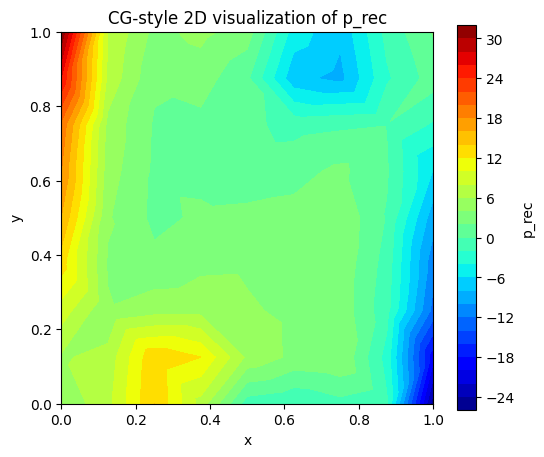

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# ------------------------------------------------------
# Assume:
#   Omega  : your bulk mesh
#   V_m    : CG1 space on Omega
#   p_rec  : fem.Function(V_m) from local FE reconstruction
# ------------------------------------------------------

coords3d = Omega.geometry.x          # (Nvertices, 3)
p_dofs   = p_rec.x.array             # nodal values (CG1 DOFs)

# ---- 1. Collapse 3D → 2D and merge columns with same (x,y) ----
xy = coords3d[:, :2]                 # drop z

# group nodes with same (x,y) (within tolerance)
tol = 1e-10
xy_rounded = np.round(xy / tol) * tol

# unique (x,y) points, and map from old vertices to these unique points
xy_unique, inverse, counts = np.unique(
    xy_rounded, axis=0, return_inverse=True, return_counts=True
)

# average p over nodes that share the same (x,y)
p_unique = np.zeros(len(xy_unique))
np.add.at(p_unique, inverse, p_dofs)
p_unique /= counts

x2d = xy_unique[:, 0]
y2d = xy_unique[:, 1]

# ---- 2. Build a 2D triangulation in (x,y) ----
# Let matplotlib create a Delaunay triangulation in 2D
triang = tri.Triangulation(x2d, y2d)

# ---- 3. Plot CG-style field (linear on triangles) ----
plt.figure(figsize=(6, 5))

# Option A: smooth filled contour
tcf = plt.tricontourf(triang, p_unique, levels=30, cmap="jet")
plt.colorbar(tcf, label="p_rec")

# Option B (comment out A, uncomment B) for piecewise linear color:
# tpc = plt.tripcolor(triang, p_unique, shading="gouraud")
# plt.colorbar(tpc, label="p_rec")

plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("CG-style 2D visualization of p_rec")
plt.show()
